In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
!pip install lifelines optuna shap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=df91a3ee0c2e02b767f116540f22b95f0a8b09bf3d02d4a0a4601371223fa7ca
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [3]:
!pip install lifelines optuna shap category_encoders imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 28.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder

# 1. Load data
train_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

targets = ['efs', 'efs_time']
y_train = train_df[targets]
X_train = train_df.drop(columns=targets)
X_test_ids = test_df['ID']
X_test = test_df.drop(columns=['ID'])

# 2. Detect column types
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.drop('ID', errors='ignore').tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# 2b. Pop race_group safely
if "race_group" in X_train.columns:
    race_train = X_train.pop("race_group").astype(str)
else:
    raise KeyError("race_group not found in training data")

if "race_group" in X_test.columns:
    race_test = X_test.pop("race_group").astype(str)
else:
    raise KeyError("race_group not found in test data")

if "race_group" in cat_cols:
    cat_cols.remove("race_group")

# 3. Impute missing values
def knn_impute(df, num_cols, cat_cols):
    df[num_cols] = KNNImputer(n_neighbors=5).fit_transform(df[num_cols])
    df[cat_cols] = df[cat_cols].fillna("Missing")
    return df

X_train = knn_impute(X_train, num_cols, cat_cols)
X_test = knn_impute(X_test, num_cols, cat_cols)

# 4. Ordinal encode categorical features
cat_encoder = OrdinalEncoder(cols=cat_cols)
X_train[cat_cols] = cat_encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_encoder.transform(X_test[cat_cols])

# 5. Ordinal encode race_group separately
race_encoder = OrdinalEncoder(cols=["race_group"])
race_train_enc = race_encoder.fit_transform(pd.DataFrame(race_train, columns=["race_group"]))
race_test_enc = race_encoder.transform(pd.DataFrame(race_test, columns=["race_group"]))

# Reinsert race_group
X_train["race_group"] = race_train_enc.values
X_test["race_group"] = race_test_enc.values

# Add race_group back to cat_cols if missing
if "race_group" not in cat_cols:
    cat_cols.append("race_group")

# 6. Scale numeric features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 7. Align test columns to training columns
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

# 8. Save processed datasets
X_train.to_csv("/kaggle/working/X_train_preprocessed.csv", index=False)
y_train.to_csv("/kaggle/working/y_train_preprocessed.csv", index=False)
X_test.to_csv("/kaggle/working/X_test_preprocessed.csv", index=False)

# 9. Log shapes
print(f"✅ Processed Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"✅ Processed Test Set Shape:     {X_test.shape}")


✅ Processed Training Set Shape: (28800, 58), (28800, 2)
✅ Processed Test Set Shape:     (3, 58)


In [5]:
!pip install lifelines

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import random
import os
import warnings
from collections import defaultdict
from torch.nn.utils import clip_grad_norm_
from typing import Dict, Tuple, Optional

warnings.filterwarnings("ignore")

# Seed & device setup
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configurations
class Config:
    EMBED_DIM = 64
    NUM_HEADS = 8
    NUM_LAYERS = 4
    FF_DIM = 512
    DROPOUT = 0.2
    LR = 2e-4
    WEIGHT_DECAY = 1e-5
    BATCH_SIZE = 64
    LAMBDA_FAIR = 0.2
    EPOCHS = 500
    EARLY_STOP_PATIENCE = 15
    GRAD_CLIP = 1.0
    DATA_PATH = "./data/"
    NUM_WORKERS = 4 if torch.cuda.is_available() else 0  # Adjust based on GPU availability

config = Config()

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        return x + self.position_embeddings(positions)

class FeatureAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1, bias=False)
        )
        
    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=1)
        return (x * attn_weights).sum(dim=1)

class SurvFormer(nn.Module):
    def __init__(self, cat_dims: Tuple[int], num_num_features: int, config: Config):
        super().__init__()
        self.config = config

        # Categorical embeddings with LayerNorm
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Embedding(cat_dim, self.config.EMBED_DIM),
                nn.LayerNorm(self.config.EMBED_DIM)
            ) for cat_dim in cat_dims
        ])

        self.seq_len = len(cat_dims) + num_num_features

        # Numerical features projection
        self.num_proj = nn.Sequential(
            nn.Linear(num_num_features, self.config.EMBED_DIM),
            nn.LayerNorm(self.config.EMBED_DIM)
        )

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.config.EMBED_DIM,
            nhead=config.NUM_HEADS,
            dim_feedforward=self.config.FF_DIM,
            dropout=config.DROPOUT,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_LAYERS)
        
        self.pos_encoder = LearnablePositionalEncoding(self.config.EMBED_DIM, max_len=self.seq_len)
        self.pooling = FeatureAttentionPooling(self.config.EMBED_DIM)
        
        self.output = nn.Sequential(
            nn.Linear(self.config.EMBED_DIM, self.config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.LayerNorm(self.config.EMBED_DIM // 2),
            nn.Linear(self.config.EMBED_DIM // 2, 1)
        )

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        batch_size = x_cat.size(0)
        cat_embeds = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        num_embeds = self.num_proj(x_num).unsqueeze(1)
        x = torch.cat([cat_embeds, num_embeds], dim=1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.pooling(x)
        return self.output(x).squeeze(-1)

def fairness_aware_loss(
    risk_scores: torch.Tensor,
    y_time: torch.Tensor,
    y_event: torch.Tensor,
    race_groups: torch.Tensor,
    lambda_fair: float = 0.2,
    group_weights: Optional[Dict[int, float]] = None
) -> Tuple[torch.Tensor, float, float, Dict[int, float]]:
    # Cox loss calculation
    order = torch.argsort(y_time, descending=True)
    risks_ordered = risk_scores[order]
    events_ordered = y_event[order]
    log_cumsum = torch.logcumsumexp(risks_ordered.clamp(-50, 50), dim=0)
    cox_loss = torch.mean((-risks_ordered + log_cumsum) * events_ordered)

    # Calculate overall C-index
    try:
        overall_c_index = concordance_index(
            y_time.cpu().numpy(),
            -risk_scores.detach().cpu().numpy(),
            y_event.cpu().numpy()
        )
    except Exception:
        overall_c_index = 0.5

    # Calculate C-indices per group
    c_indices = {}
    for race in torch.unique(race_groups):
        mask = race_groups == race
        if mask.sum() > 1:  # Need at least 2 samples to calculate C-index
            try:
                c_idx = concordance_index(
                    y_time[mask].cpu().numpy(),
                    -risk_scores[mask].detach().cpu().numpy(),
                    y_event[mask].cpu().numpy()
                )
            except Exception:
                c_idx = 0.5
            c_indices[race.item()] = c_idx

    # Enhanced penalty calculation
    penalty = 0.0
    if len(c_indices) > 0:
        if group_weights is None:
            group_weights = {race: 1.0 for race in c_indices.keys()}
        
        # Calculate weighted squared differences
        weighted_diffs = []
        for race, c_idx in c_indices.items():
            weight = group_weights.get(race, 1.0)
            weighted_diffs.append(weight * (overall_c_index - c_idx)**2)
        
        # Scale penalty to be comparable to Cox loss
        penalty = sum(weighted_diffs) / len(weighted_diffs)
        penalty = penalty * (1.0 + lambda_fair)  # Additional scaling
        
    loss = cox_loss + lambda_fair * penalty
    
    return loss, overall_c_index, penalty, c_indices

def compute_group_weights(c_indices: Dict[int, float]) -> Dict[int, float]:
    """Compute meaningful weights that amplify performance differences"""
    if not c_indices:
        return {}
    
    avg_cindex = np.mean(list(c_indices.values()))
    weights = {}
    for group, cidx in c_indices.items():
        # More aggressive weighting (1.0 = no change, <1 for better, >1 for worse)
        weight = 1.0 + (avg_cindex - cidx) * 2.0  # Scale factor of 2.0
        weights[group] = max(0.5, min(2.0, weight))  # Clip between 0.5-2.0
    return weights

class SurvivalDataset(Dataset):
    def __init__(self, x_cat: np.ndarray, x_num: np.ndarray, 
                 y_time: np.ndarray, y_event: np.ndarray, 
                 race: np.ndarray):
        self.x_cat = x_cat
        self.x_num = x_num
        self.y_time = y_time
        self.y_event = y_event
        self.race = race

    def __len__(self):
        return len(self.y_time)

    def __getitem__(self, idx):
        return (
            self.x_cat[idx],
            self.x_num[idx],
            self.y_time[idx],
            self.y_event[idx],
            self.race[idx]
        )
def train_and_evaluate(config: Config, n_splits: int = 5) -> Dict:
    """Enhanced training and evaluation with all improvements"""
    try:
        X = pd.read_csv("/kaggle/working/X_train_preprocessed.csv")
        y = pd.read_csv("/kaggle/working/y_train_preprocessed.csv")
    except FileNotFoundError:
        raise FileNotFoundError("Data files not found in /kaggle/working/")

    # Data validation and preprocessing
    race_all = X.pop("race_group").astype(int)
    
    cat_features = [
        'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia',
        'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct',
        'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail',
        'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd',
        'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph',
        'rheum_issue', 'sex_match', 'hepatic_mild', 'tce_div_match',
        'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']

    for feat in cat_features:
        if not pd.api.types.is_integer_dtype(X[feat]):
            X[feat] = X[feat].astype(int)
        if X[feat].min() < 0:
            raise ValueError(f"Categorical feature {feat} contains negative values")

    num_features = [col for col in X.columns if col not in cat_features]
    scaler = StandardScaler()
    X[num_features] = scaler.fit_transform(X[num_features])
    
    if np.isinf(X[num_features]).any().any() or np.isnan(X[num_features]).any().any():
        raise ValueError("Numerical features contain NaN or inf after scaling")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_best_val_cindex = -np.inf
    global_best_model_state = None
    
    # Initialize metrics storage (without lambda functions)
    fold_metrics = {
        'train': {'loss': [], 'cindex': [], 'penalty': []},
        'val': {'loss': [], 'cindex': [], 'penalty': []},
        'train_race_cindices': {fold: {} for fold in range(n_splits)},
        'val_race_cindices': {fold: {} for fold in range(n_splits)},
        'fold_summaries': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold+1}/{n_splits}")

        race_train = race_all.iloc[train_idx].values.astype(int)
        race_val = race_all.iloc[val_idx].values.astype(int)
        
        for race in np.unique(race_train):
            if (race_train == race).sum() < 2:
                warnings.warn(f"Race group {race} has less than 2 samples in training set")
        
        for race in np.unique(race_val):
            if (race_val == race).sum() < 2:
                warnings.warn(f"Race group {race} has less than 2 samples in validation set")

        X_train_cat = X.iloc[train_idx][cat_features].values
        X_val_cat = X.iloc[val_idx][cat_features].values
        X_train_num = X.iloc[train_idx][num_features].values.astype(np.float32)
        X_val_num = X.iloc[val_idx][num_features].values.astype(np.float32)
        y_train_time = y.iloc[train_idx]['efs_time'].values.astype(np.float32)
        y_val_time = y.iloc[val_idx]['efs_time'].values.astype(np.float32)
        y_train_event = y.iloc[train_idx]['efs'].values.astype(np.float32)
        y_val_event = y.iloc[val_idx]['efs'].values.astype(np.float32)

        train_dataset = SurvivalDataset(
            torch.tensor(X_train_cat, dtype=torch.long),
            torch.tensor(X_train_num, dtype=torch.float32),
            torch.tensor(y_train_time, dtype=torch.float32),
            torch.tensor(y_train_event, dtype=torch.float32),
            torch.tensor(race_train, dtype=torch.long),
        )

        val_dataset = SurvivalDataset(
            torch.tensor(X_val_cat, dtype=torch.long),
            torch.tensor(X_val_num, dtype=torch.float32),
            torch.tensor(y_val_time, dtype=torch.float32),
            torch.tensor(y_val_event, dtype=torch.float32),
            torch.tensor(race_val, dtype=torch.long),
        )

        train_loader = DataLoader(
            train_dataset, 
            batch_size=config.BATCH_SIZE, 
            shuffle=True,
            num_workers=config.NUM_WORKERS,
            pin_memory=torch.cuda.is_available()
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=config.BATCH_SIZE, 
            shuffle=False,
            num_workers=config.NUM_WORKERS,
            pin_memory=torch.cuda.is_available()
        )

        # Model initialization
        cat_dims = [int(X[feat].max() + 1) for feat in cat_features]
        model = SurvFormer(cat_dims, len(num_features), config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

        best_val_cindex = -np.inf
        best_model_state = None
        best_epoch = 0
        group_weights = None
        no_improve = 0
        epoch_metrics = {
            'train_loss': [],
            'train_cindex': [],
            'train_penalty': [],
            'val_loss': [],
            'val_cindex': [],
            'val_penalty': [],
            'train_race_cindices': {},
            'val_race_cindices': {}
        }

        for epoch in range(config.EPOCHS):
            model.train()
            train_losses = []
            all_risk_scores = []
            all_times = []
            all_events = []
            all_races = []

            for batch in train_loader:
                x_cat, x_num, y_time, y_event, race = [b.to(device, non_blocking=True) for b in batch]
                optimizer.zero_grad(set_to_none=True)
                risk_scores = model(x_cat, x_num)
                loss, overall_cidx, penalty, c_indices = fairness_aware_loss(
                    risk_scores, y_time, y_event, race, 
                    lambda_fair=config.LAMBDA_FAIR, 
                    group_weights=group_weights
                )
                loss.backward()
                clip_grad_norm_(model.parameters(), config.GRAD_CLIP)
                optimizer.step()
                train_losses.append(loss.item())
                all_risk_scores.append(risk_scores.detach().cpu())
                all_times.append(y_time.cpu())
                all_events.append(y_event.cpu())
                all_races.append(race.cpu())

            all_risk_scores = torch.cat(all_risk_scores)
            all_times = torch.cat(all_times)
            all_events = torch.cat(all_events)
            all_races = torch.cat(all_races)

            train_overall_cindex = concordance_index(
                all_times.numpy(),
                -all_risk_scores.numpy(),
                all_events.numpy()
            )

            train_c_indices = {}
            for r in torch.unique(all_races):
                mask = all_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        all_times[mask].numpy(),
                        -all_risk_scores[mask].numpy(),
                        all_events[mask].numpy()
                    )
                    if r.item() not in epoch_metrics['train_race_cindices']:
                        epoch_metrics['train_race_cindices'][r.item()] = []
                    epoch_metrics['train_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                train_c_indices[r.item()] = cidx
            
            train_penalty = np.nanmean(
                [(train_overall_cindex - c)**2 for c in train_c_indices.values() if not np.isnan(c)]
            )
            
            epoch_metrics['train_loss'].append(np.mean(train_losses))
            epoch_metrics['train_cindex'].append(train_overall_cindex)
            epoch_metrics['train_penalty'].append(train_penalty)

            # Validation phase
            model.eval()
            val_risk_scores = []
            val_times = []
            val_events = []
            val_races = []
            val_losses = []

            with torch.no_grad():
                for batch in val_loader:
                    x_cat, x_num, y_time, y_event, race = [b.to(device, non_blocking=True) for b in batch]
                    risks = model(x_cat, x_num)
                    loss, _, _, _ = fairness_aware_loss(
                        risks, y_time, y_event, race,
                        lambda_fair=config.LAMBDA_FAIR,
                        group_weights=group_weights
                    )
                    val_losses.append(loss.item())
                    val_risk_scores.append(risks.cpu())
                    val_times.append(y_time.cpu())
                    val_events.append(y_event.cpu())
                    val_races.append(race.cpu())

            val_risk_scores = torch.cat(val_risk_scores)
            val_times = torch.cat(val_times)
            val_events = torch.cat(val_events)
            val_races = torch.cat(val_races)

            val_overall_cindex = concordance_index(
                val_times.numpy(),
                -val_risk_scores.numpy(),
                val_events.numpy()
            )

            val_c_indices = {}
            for r in torch.unique(val_races):
                mask = val_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        val_times[mask].numpy(),
                        -val_risk_scores[mask].numpy(),
                        val_events[mask].numpy()
                    )
                    if r.item() not in epoch_metrics['val_race_cindices']:
                        epoch_metrics['val_race_cindices'][r.item()] = []
                    epoch_metrics['val_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                val_c_indices[r.item()] = cidx
            
            val_penalty = np.nanmean(
                [(val_overall_cindex - c)**2 for c in val_c_indices.values() if not np.isnan(c)]
            )
            
            epoch_metrics['val_loss'].append(np.mean(val_losses))
            epoch_metrics['val_cindex'].append(val_overall_cindex)
            epoch_metrics['val_penalty'].append(val_penalty)

            scheduler.step(val_overall_cindex)

            if len(train_c_indices) > 0:
                group_weights = compute_group_weights(train_c_indices)

            if val_overall_cindex > best_val_cindex:
                best_val_cindex = val_overall_cindex
                best_model_state = model.state_dict()
                best_epoch = epoch + 1
                no_improve = 0
                # Save per-fold best model to Kaggle working directory
                fold_save_path = f"/kaggle/working/fold_{fold}_best_model.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_cindex': val_overall_cindex,
                }, fold_save_path)
            else:
                no_improve += 1
                if no_improve >= config.EARLY_STOP_PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Store fold summary
        fold_summary = {
            'best_epoch': best_epoch,
            'best_train_loss': epoch_metrics['train_loss'][best_epoch-1],
            'best_train_cindex': epoch_metrics['train_cindex'][best_epoch-1],
            'best_train_penalty': epoch_metrics['train_penalty'][best_epoch-1],
            'best_val_loss': epoch_metrics['val_loss'][best_epoch-1],
            'best_val_cindex': epoch_metrics['val_cindex'][best_epoch-1],
            'best_val_penalty': epoch_metrics['val_penalty'][best_epoch-1],
            'train_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['train_race_cindices'].items()
            },
            'val_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['val_race_cindices'].items()
            }
        }
        fold_metrics['fold_summaries'].append(fold_summary)

        # Update global best model
        if best_val_cindex > global_best_val_cindex:
            global_best_val_cindex = best_val_cindex
            global_best_model_state = best_model_state

        print(f"\n📊 Fold {fold+1} Summary:")
        print(f"Best Epoch: {best_epoch}")
        print(f"Training - Loss: {fold_summary['best_train_loss']:.4f}, "
              f"C-index: {fold_summary['best_train_cindex']:.4f}, "
              f"Penalty: {fold_summary['best_train_penalty']:.4f}")
        print(f"Validation - Loss: {fold_summary['best_val_loss']:.4f}, "
              f"C-index: {fold_summary['best_val_cindex']:.4f}, "
              f"Penalty: {fold_summary['best_val_penalty']:.4f}")
        
        print("\nTraining per-race C-indices:")
        for race, cidx in fold_summary['train_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")
        
        print("\nValidation per-race C-indices:")
        for race, cidx in fold_summary['val_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")

    # Save global best model to Kaggle working directory
    if global_best_model_state is not None:
        save_path = "/kaggle/working/best_model.pth"
        torch.save({
            'model_state_dict': global_best_model_state,
            'config': vars(config),
            'metrics': fold_metrics
        }, save_path)
        print(f"\n🎉 Saved best model with val C-index {global_best_val_cindex:.4f} as '{save_path}'")
    
    # Process results
    results = {
        'fold_summaries': fold_metrics['fold_summaries'],
        'train': {
            'loss': [s['best_train_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_train_cindex'] for s in fold_metrics['fold_summaries']],
            'penalty': [s['best_train_penalty'] for s in fold_metrics['fold_summaries']],
        },
        'val': {
            'loss': [s['best_val_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_val_cindex'] for s in fold_metrics['fold_summaries']],
            'penalty': [s['best_val_penalty'] for s in fold_metrics['fold_summaries']],
        },
        'train_race_cindices': fold_metrics['train_race_cindices'],
        'val_race_cindices': fold_metrics['val_race_cindices']
    }
    
    print("\n=== Final Cross-Validation Results ===")
    print(f"Average Training Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['train']['loss']):.4f} ± {np.std(results['train']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['train']['cindex']):.4f} ± {np.std(results['train']['cindex']):.4f}")
    print(f"  Fairness Penalty: {np.mean(results['train']['penalty']):.4f} ± {np.std(results['train']['penalty']):.4f}")

    print(f"\nAverage Validation Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['val']['loss']):.4f} ± {np.std(results['val']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['val']['cindex']):.4f} ± {np.std(results['val']['cindex']):.4f}")
    print(f"  Fairness Penalty: {np.mean(results['val']['penalty']):.4f} ± {np.std(results['val']['penalty']):.4f}")

    print("\nPer-Race C-indices Summary (averaged across folds):")
    all_races = set()
    for fold_data in results['val_race_cindices'].values():
        all_races.update(fold_data.keys())

    race_metrics = []
    for race in sorted(all_races):
        train_c = []
        val_c = []
        for fold in range(len(results['val_race_cindices'])):
            if race in results['train_race_cindices'][fold]:
                train_c.append(results['train_race_cindices'][fold][race])
            if race in results['val_race_cindices'][fold]:
                val_c.append(results['val_race_cindices'][fold][race])
        
        if train_c and val_c:
            train_mean = np.nanmean(train_c)
            train_std = np.nanstd(train_c)
            val_mean = np.nanmean(val_c)
            val_std = np.nanstd(val_c)
            race_metrics.append((race, train_mean, train_std, val_mean, val_std))

    print("\nRace\tTrain C-index (Mean±Std)\tValidation C-index (Mean±Std)")
    for race, train_mean, train_std, val_mean, val_std in sorted(race_metrics, key=lambda x: x[0]):
        print(f"{race}\t{train_mean:.4f}±{train_std:.4f}\t\t{val_mean:.4f}±{val_std:.4f}")

    best_fold = np.argmax([s['best_val_cindex'] for s in results['fold_summaries']])
    print(f"\n🌟 Best Fold: {best_fold+1}")
    print(f"  Training C-index: {results['fold_summaries'][best_fold]['best_train_cindex']:.4f}")
    print(f"  Validation C-index: {results['fold_summaries'][best_fold]['best_val_cindex']:.4f}")

    return results
  # Run the training and evaluation
results = train_and_evaluate(config)  


🔁 Fold 1/5
Early stopping at epoch 31

📊 Fold 1 Summary:
Best Epoch: 16
Training - Loss: 1.9593, C-index: 0.6751, Penalty: 0.0002
Validation - Loss: 1.9488, C-index: 0.6740, Penalty: 0.0003

Training per-race C-indices:
  Race 1: 0.6779
  Race 2: 0.6830
  Race 3: 0.6520
  Race 4: 0.6801
  Race 5: 0.6658
  Race 6: 0.6616

Validation per-race C-indices:
  Race 1: 0.6825
  Race 2: 0.6847
  Race 3: 0.6343
  Race 4: 0.6733
  Race 5: 0.6669
  Race 6: 0.6754

🔁 Fold 2/5
Early stopping at epoch 23

📊 Fold 2 Summary:
Best Epoch: 8
Training - Loss: 1.9557, C-index: 0.6593, Penalty: 0.0001
Validation - Loss: 2.0040, C-index: 0.6752, Penalty: 0.0003

Training per-race C-indices:
  Race 1: 0.6749
  Race 2: 0.6804
  Race 3: 0.6500
  Race 4: 0.6725
  Race 5: 0.6622
  Race 6: 0.6622

Validation per-race C-indices:
  Race 1: 0.6799
  Race 2: 0.6907
  Race 3: 0.6389
  Race 4: 0.6860
  Race 5: 0.6736
  Race 6: 0.6515

🔁 Fold 3/5
Early stopping at epoch 24

📊 Fold 3 Summary:
Best Epoch: 9
Training - Loss

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import random
import os
import warnings
from collections import defaultdict
from torch.nn.utils import clip_grad_norm_
from typing import Dict, Tuple, Optional

warnings.filterwarnings("ignore")

# Seed & device setup
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configurations
class Config:
    EMBED_DIM = 64
    NUM_HEADS = 8
    NUM_LAYERS = 4
    FF_DIM = 512
    DROPOUT = 0.2
    LR = 2e-4
    WEIGHT_DECAY = 1e-5
    BATCH_SIZE = 64
    LAMBDA_FAIR = 0.2
    EPOCHS = 500
    EARLY_STOP_PATIENCE = 15
    GRAD_CLIP = 1.0
    DATA_PATH = "./data/"
    NUM_WORKERS = 4 if torch.cuda.is_available() else 0

config = Config()

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        return x + self.position_embeddings(positions)

class FeatureAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1, bias=False)
        )
        
    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=1)
        return (x * attn_weights).sum(dim=1)

class SurvFormer(nn.Module):
    def __init__(self, cat_dims: Tuple[int], num_num_features: int, config: Config):
        super().__init__()
        self.config = config
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Embedding(cat_dim, self.config.EMBED_DIM),
                nn.LayerNorm(self.config.EMBED_DIM)
            ) for cat_dim in cat_dims
        ])
        self.seq_len = len(cat_dims) + num_num_features
        self.num_proj = nn.Sequential(
            nn.Linear(num_num_features, self.config.EMBED_DIM),
            nn.LayerNorm(self.config.EMBED_DIM)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.config.EMBED_DIM,
            nhead=config.NUM_HEADS,
            dim_feedforward=self.config.FF_DIM,
            dropout=config.DROPOUT,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_LAYERS)
        self.pos_encoder = LearnablePositionalEncoding(self.config.EMBED_DIM, max_len=self.seq_len)
        self.pooling = FeatureAttentionPooling(self.config.EMBED_DIM)
        self.output = nn.Sequential(
            nn.Linear(self.config.EMBED_DIM, self.config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.LayerNorm(self.config.EMBED_DIM // 2),
            nn.Linear(self.config.EMBED_DIM // 2, 1)
        )

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        batch_size = x_cat.size(0)
        cat_embeds = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        num_embeds = self.num_proj(x_num).unsqueeze(1)
        x = torch.cat([cat_embeds, num_embeds], dim=1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.pooling(x)
        return self.output(x).squeeze(-1)

def standard_cox_loss(risk_scores, y_time, y_event):
    order = torch.argsort(y_time, descending=True)
    risks_ordered = risk_scores[order]
    events_ordered = y_event[order]
    log_cumsum = torch.logcumsumexp(risks_ordered, dim=0)
    return torch.mean((-risks_ordered + log_cumsum) * events_ordered)

class SurvivalDataset(Dataset):
    def __init__(self, x_cat: np.ndarray, x_num: np.ndarray, y_time: np.ndarray, y_event: np.ndarray, race: np.ndarray):
        self.x_cat = x_cat
        self.x_num = x_num
        self.y_time = y_time
        self.y_event = y_event
        self.race = race

    def __getitem__(self, idx):
        return (
            torch.as_tensor(self.x_cat[idx], dtype=torch.long),
            torch.as_tensor(self.x_num[idx], dtype=torch.float32),
            torch.as_tensor(self.y_time[idx], dtype=torch.float32),
            torch.as_tensor(self.y_event[idx], dtype=torch.float32),
            torch.as_tensor(self.race[idx], dtype=torch.long)
        )

    def __len__(self):
        return len(self.x_cat)

def train_and_evaluate(config: Config, n_splits: int = 5) -> Dict:
    try:
        X = pd.read_csv("/kaggle/working/X_train_preprocessed.csv")
        y = pd.read_csv("/kaggle/working/y_train_preprocessed.csv")
    except FileNotFoundError:
        raise FileNotFoundError("Data files not found in /kaggle/working/")

    race_all = X.pop("race_group").astype(int)
    cat_features = ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia',
                   'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct',
                   'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail',
                   'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd',
                   'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph',
                   'rheum_issue', 'sex_match', 'hepatic_mild', 'tce_div_match',
                   'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']

    num_features = [col for col in X.columns if col not in cat_features]
    scaler = StandardScaler()
    X[num_features] = scaler.fit_transform(X[num_features])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_best_val_cindex = -np.inf
    global_best_model_state = None
    fold_metrics = {
        'train': {'loss': [], 'cindex': []},
        'val': {'loss': [], 'cindex': []},
        'train_race_cindices': defaultdict(list),
        'val_race_cindices': defaultdict(list),
        'fold_summaries': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold+1}/{n_splits}")

        X_train_cat = X.iloc[train_idx][cat_features].values
        X_val_cat = X.iloc[val_idx][cat_features].values
        X_train_num = X.iloc[train_idx][num_features].values.astype(np.float32)
        X_val_num = X.iloc[val_idx][num_features].values.astype(np.float32)
        y_train_time = y.iloc[train_idx]['efs_time'].values.astype(np.float32)
        y_val_time = y.iloc[val_idx]['efs_time'].values.astype(np.float32)
        y_train_event = y.iloc[train_idx]['efs'].values.astype(np.float32)
        y_val_event = y.iloc[val_idx]['efs'].values.astype(np.float32)
        race_train = race_all.iloc[train_idx].values.astype(int)
        race_val = race_all.iloc[val_idx].values.astype(int)

        train_dataset = SurvivalDataset(X_train_cat, X_train_num, y_train_time, y_train_event, race_train)
        val_dataset = SurvivalDataset(X_val_cat, X_val_num, y_val_time, y_val_event, race_val)

        train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

        cat_dims = [int(X[feat].max() + 1) for feat in cat_features]
        model = SurvFormer(cat_dims, len(num_features), config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

        best_val_cindex = -np.inf
        best_model_state = None
        best_epoch = 0
        no_improve = 0
        epoch_metrics = {
            'train_loss': [],
            'train_cindex': [],
            'val_loss': [],
            'val_cindex': [],
            'train_race_cindices': defaultdict(list),
            'val_race_cindices': defaultdict(list)
        }

        for epoch in range(config.EPOCHS):
            model.train()
            train_losses = []
            all_risk_scores = []
            all_times = []
            all_events = []
            all_races = []

            for batch in train_loader:
                x_cat, x_num, y_time, y_event, race = [b.to(device) for b in batch]
                optimizer.zero_grad()
                risk_scores = model(x_cat, x_num)
                loss = standard_cox_loss(risk_scores, y_time, y_event)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                all_risk_scores.append(risk_scores.detach().cpu())
                all_times.append(y_time.cpu())
                all_events.append(y_event.cpu())
                all_races.append(race.cpu())

            all_risk_scores = torch.cat(all_risk_scores)
            all_times = torch.cat(all_times)
            all_events = torch.cat(all_events)
            all_races = torch.cat(all_races)

            train_overall_cindex = concordance_index(
                all_times.numpy(), -all_risk_scores.numpy(), all_events.numpy()
            )

            train_c_indices = {}
            for r in torch.unique(all_races):
                mask = all_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        all_times[mask].numpy(), -all_risk_scores[mask].numpy(), all_events[mask].numpy()
                    )
                    epoch_metrics['train_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                train_c_indices[r.item()] = cidx
            
            epoch_metrics['train_loss'].append(np.mean(train_losses))
            epoch_metrics['train_cindex'].append(train_overall_cindex)

            # Validation
            model.eval()
            val_risk_scores = []
            val_times = []
            val_events = []
            val_races = []
            val_losses = []

            with torch.no_grad():
                for batch in val_loader:
                    x_cat, x_num, y_time, y_event, race = [b.to(device) for b in batch]
                    risks = model(x_cat, x_num)
                    loss = standard_cox_loss(risks, y_time, y_event)
                    val_losses.append(loss.item())
                    val_risk_scores.append(risks.cpu())
                    val_times.append(y_time.cpu())
                    val_events.append(y_event.cpu())
                    val_races.append(race.cpu())

            val_risk_scores = torch.cat(val_risk_scores)
            val_times = torch.cat(val_times)
            val_events = torch.cat(val_events)
            val_races = torch.cat(val_races)

            val_overall_cindex = concordance_index(
                val_times.numpy(), -val_risk_scores.numpy(), val_events.numpy()
            )

            val_c_indices = {}
            for r in torch.unique(val_races):
                mask = val_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        val_times[mask].numpy(), -val_risk_scores[mask].numpy(), val_events[mask].numpy()
                    )
                    epoch_metrics['val_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                val_c_indices[r.item()] = cidx
            
            epoch_metrics['val_loss'].append(np.mean(val_losses))
            epoch_metrics['val_cindex'].append(val_overall_cindex)

            scheduler.step(val_overall_cindex)

            if val_overall_cindex > best_val_cindex:
                best_val_cindex = val_overall_cindex
                best_model_state = model.state_dict()
                best_epoch = epoch + 1
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= config.EARLY_STOP_PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        fold_summary = {
            'best_epoch': best_epoch,
            'best_train_loss': epoch_metrics['train_loss'][best_epoch-1],
            'best_train_cindex': epoch_metrics['train_cindex'][best_epoch-1],
            'best_val_loss': epoch_metrics['val_loss'][best_epoch-1],
            'best_val_cindex': epoch_metrics['val_cindex'][best_epoch-1],
            'train_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['train_race_cindices'].items()
            },
            'val_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['val_race_cindices'].items()
            }
        }
        fold_metrics['fold_summaries'].append(fold_summary)

        if best_val_cindex > global_best_val_cindex:
            global_best_val_cindex = best_val_cindex
            global_best_model_state = best_model_state

        print(f"\n📊 Fold {fold+1} Summary:")
        print(f"Best Epoch: {best_epoch}")
        print(f"Training - Loss: {fold_summary['best_train_loss']:.4f}, C-index: {fold_summary['best_train_cindex']:.4f}")
        print(f"Validation - Loss: {fold_summary['best_val_loss']:.4f}, C-index: {fold_summary['best_val_cindex']:.4f}")
        
        print("\nTraining per-race C-indices:")
        for race, cidx in fold_summary['train_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")
        
        print("\nValidation per-race C-indices:")
        for race, cidx in fold_summary['val_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")

    if global_best_model_state is not None:
        save_path = "/kaggle/working/best_model_no_fairness.pth"
        torch.save({
            'model_state_dict': global_best_model_state,
            'config': vars(config),
            'metrics': fold_metrics
        }, save_path)
        print(f"\n🎉 Saved best model with val C-index {global_best_val_cindex:.4f} as '{save_path}'")
    
    results = {
        'fold_summaries': fold_metrics['fold_summaries'],
        'train': {
            'loss': [s['best_train_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_train_cindex'] for s in fold_metrics['fold_summaries']],
        },
        'val': {
            'loss': [s['best_val_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_val_cindex'] for s in fold_metrics['fold_summaries']],
        },
        'train_race_cindices': defaultdict(dict),
        'val_race_cindices': defaultdict(dict)
    }
    
    for fold, summary in enumerate(fold_metrics['fold_summaries']):
        for race, cidx in summary['train_race_cindices'].items():
            results['train_race_cindices'][race][fold] = cidx
        for race, cidx in summary['val_race_cindices'].items():
            results['val_race_cindices'][race][fold] = cidx
    
    print("\n=== Final Cross-Validation Results ===")
    print(f"Average Training Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['train']['loss']):.4f} ± {np.std(results['train']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['train']['cindex']):.4f} ± {np.std(results['train']['cindex']):.4f}")

    print(f"\nAverage Validation Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['val']['loss']):.4f} ± {np.std(results['val']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['val']['cindex']):.4f} ± {np.std(results['val']['cindex']):.4f}")

    print("\nPer-Race C-indices Summary (averaged across folds):")
    all_races = set()
    for race_data in results['val_race_cindices'].values():
        all_races.update(race_data.keys())

    race_metrics = []
    for race in sorted(all_races):
        train_c = []
        val_c = []
        for fold in range(len(results['fold_summaries'])):
            if race in results['train_race_cindices'] and fold in results['train_race_cindices'][race]:
                train_c.append(results['train_race_cindices'][race][fold])
            if race in results['val_race_cindices'] and fold in results['val_race_cindices'][race]:
                val_c.append(results['val_race_cindices'][race][fold])
        
        if train_c and val_c:
            train_mean = np.nanmean(train_c)
            train_std = np.nanstd(train_c)
            val_mean = np.nanmean(val_c)
            val_std = np.nanstd(val_c)
            race_metrics.append((race, train_mean, train_std, val_mean, val_std))

    print("\nRace\tTrain C-index (Mean±Std)\tValidation C-index (Mean±Std)")
    for race, train_mean, train_std, val_mean, val_std in sorted(race_metrics, key=lambda x: x[0]):
        print(f"{race}\t{train_mean:.4f}±{train_std:.4f}\t\t{val_mean:.4f}±{val_std:.4f}")

    best_fold = np.argmax([s['best_val_cindex'] for s in results['fold_summaries']])
    print(f"\n🌟 Best Fold: {best_fold+1}")
    print(f"  Training C-index: {results['fold_summaries'][best_fold]['best_train_cindex']:.4f}")
    print(f"  Validation C-index: {results['fold_summaries'][best_fold]['best_val_cindex']:.4f}")

    return results

# Run the training and evaluation
results_no_fairness = train_and_evaluate(config)


🔁 Fold 1/5
Early stopping at epoch 38

📊 Fold 1 Summary:
Best Epoch: 23
Training - Loss: 1.9420, C-index: 0.6887
Validation - Loss: 1.9441, C-index: 0.6744

Training per-race C-indices:
  Race 1: 0.6819
  Race 2: 0.6886
  Race 3: 0.6566
  Race 4: 0.6851
  Race 5: 0.6712
  Race 6: 0.6671

Validation per-race C-indices:
  Race 1: 0.6829
  Race 2: 0.6845
  Race 3: 0.6347
  Race 4: 0.6741
  Race 5: 0.6660
  Race 6: 0.6761

🔁 Fold 2/5
Early stopping at epoch 35

📊 Fold 2 Summary:
Best Epoch: 20
Training - Loss: 1.9294, C-index: 0.6835
Validation - Loss: 2.0018, C-index: 0.6767

Training per-race C-indices:
  Race 1: 0.6804
  Race 2: 0.6871
  Race 3: 0.6559
  Race 4: 0.6809
  Race 5: 0.6690
  Race 6: 0.6680

Validation per-race C-indices:
  Race 1: 0.6821
  Race 2: 0.6883
  Race 3: 0.6423
  Race 4: 0.6887
  Race 5: 0.6747
  Race 6: 0.6602

🔁 Fold 3/5
Early stopping at epoch 31

📊 Fold 3 Summary:
Best Epoch: 16
Training - Loss: 1.9522, C-index: 0.6707
Validation - Loss: 1.9440, C-index: 0.67

In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import random
import os
import warnings
from collections import defaultdict
from torch.nn.utils import clip_grad_norm_
from typing import Dict, Tuple, Optional

warnings.filterwarnings("ignore")

# Seed & device setup
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configurations
class Config:
    EMBED_DIM = 64
    NUM_HEADS = 8
    NUM_LAYERS = 4
    FF_DIM = 512
    DROPOUT = 0.2
    LR = 2e-4
    WEIGHT_DECAY = 1e-5
    BATCH_SIZE = 64
    LAMBDA_FAIR = 0.2
    EPOCHS = 500
    EARLY_STOP_PATIENCE = 15
    GRAD_CLIP = 1.0
    DATA_PATH = "./data/"
    NUM_WORKERS = 4 if torch.cuda.is_available() else 0  # Adjust based on GPU availability

config = Config()

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        return x + self.position_embeddings(positions)

class FeatureAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1, bias=False)
        )
        
    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=1)
        return (x * attn_weights).sum(dim=1)

class SurvFormer(nn.Module):
    def __init__(self, cat_dims: Tuple[int], num_num_features: int, config: Config):
        super().__init__()
        self.config = config

        # Categorical embeddings with LayerNorm
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Embedding(cat_dim, self.config.EMBED_DIM),
                nn.LayerNorm(self.config.EMBED_DIM)
            ) for cat_dim in cat_dims
        ])

        self.seq_len = len(cat_dims) + num_num_features

        # Numerical features projection
        self.num_proj = nn.Sequential(
            nn.Linear(num_num_features, self.config.EMBED_DIM),
            nn.LayerNorm(self.config.EMBED_DIM)
        )

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.config.EMBED_DIM,
            nhead=config.NUM_HEADS,
            dim_feedforward=self.config.FF_DIM,
            dropout=config.DROPOUT,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_LAYERS)
        
        self.pos_encoder = LearnablePositionalEncoding(self.config.EMBED_DIM, max_len=self.seq_len)
        self.pooling = FeatureAttentionPooling(self.config.EMBED_DIM)
        
        self.output = nn.Sequential(
            nn.Linear(self.config.EMBED_DIM, self.config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.LayerNorm(self.config.EMBED_DIM // 2),
            nn.Linear(self.config.EMBED_DIM // 2, 1)
        )

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        batch_size = x_cat.size(0)
        cat_embeds = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        num_embeds = self.num_proj(x_num).unsqueeze(1)
        x = torch.cat([cat_embeds, num_embeds], dim=1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.pooling(x)
        return self.output(x).squeeze(-1)

def fairness_aware_loss(
    risk_scores: torch.Tensor,
    y_time: torch.Tensor,
    y_event: torch.Tensor,
    race_groups: torch.Tensor,
    lambda_fair: float = 0.2
) -> Tuple[torch.Tensor, float, float, Dict[int, float]]:
    # Cox loss calculation
    order = torch.argsort(y_time, descending=True)
    risks_ordered = risk_scores[order]
    events_ordered = y_event[order]
    log_cumsum = torch.logcumsumexp(risks_ordered.clamp(-50, 50), dim=0)
    cox_loss = torch.mean((-risks_ordered + log_cumsum) * events_ordered)

    # Calculate overall C-index
    try:
        overall_c_index = concordance_index(
            y_time.cpu().numpy(),
            -risk_scores.detach().cpu().numpy(),
            y_event.cpu().numpy()
        )
    except Exception:
        overall_c_index = 0.5

    # Calculate C-indices per group
    c_indices = {}
    for race in torch.unique(race_groups):
        mask = race_groups == race
        if mask.sum() > 1:  # Need at least 2 samples to calculate C-index
            try:
                c_idx = concordance_index(
                    y_time[mask].cpu().numpy(),
                    -risk_scores[mask].detach().cpu().numpy(),
                    y_event[mask].cpu().numpy()
                )
            except Exception:
                c_idx = 0.5
            c_indices[race.item()] = c_idx

    # Calculate fairness penalty
    penalty = 0.0
    if len(c_indices) > 0:
        # Calculate squared differences between overall and group C-indices
        squared_diffs = [(overall_c_index - c_idx)**2 for c_idx in c_indices.values()]
        penalty = np.mean(squared_diffs)
        
        # Ensure penalty is at least 0.0002
        penalty = max(penalty, 0.0002)
        
    loss = cox_loss + lambda_fair * penalty
    
    return loss, overall_c_index, penalty, c_indices

class SurvivalDataset(Dataset):
    def __init__(self, x_cat: np.ndarray, x_num: np.ndarray, 
                 y_time: np.ndarray, y_event: np.ndarray, 
                 race: np.ndarray):
        self.x_cat = x_cat
        self.x_num = x_num
        self.y_time = y_time
        self.y_event = y_event
        self.race = race

    def __len__(self):
        return len(self.y_time)

    def __getitem__(self, idx):
        return (
            self.x_cat[idx],
            self.x_num[idx],
            self.y_time[idx],
            self.y_event[idx],
            self.race[idx]
        )
def train_and_evaluate(config: Config, n_splits: int = 5) -> Dict:
    """Enhanced training and evaluation with all improvements"""
    try:
        X = pd.read_csv("/kaggle/working/X_train_preprocessed.csv")
        y = pd.read_csv("/kaggle/working/y_train_preprocessed.csv")
    except FileNotFoundError:
        raise FileNotFoundError("Data files not found in /kaggle/working/")

    # Data validation and preprocessing
    race_all = X.pop("race_group").astype(int)
    
    cat_features = [
        'dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia',
        'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct',
        'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail',
        'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd',
        'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph',
        'rheum_issue', 'sex_match', 'hepatic_mild', 'tce_div_match',
        'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']

    for feat in cat_features:
        if not pd.api.types.is_integer_dtype(X[feat]):
            X[feat] = X[feat].astype(int)
        if X[feat].min() < 0:
            raise ValueError(f"Categorical feature {feat} contains negative values")

    num_features = [col for col in X.columns if col not in cat_features]
    scaler = StandardScaler()
    X[num_features] = scaler.fit_transform(X[num_features])
    
    if np.isinf(X[num_features]).any().any() or np.isnan(X[num_features]).any().any():
        raise ValueError("Numerical features contain NaN or inf after scaling")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_best_val_cindex = -np.inf
    global_best_model_state = None
    
    # Initialize metrics storage (without lambda functions)
    fold_metrics = {
        'train': {'loss': [], 'cindex': [], 'penalty': []},
        'val': {'loss': [], 'cindex': [], 'penalty': []},
        'train_race_cindices': {fold: {} for fold in range(n_splits)},
        'val_race_cindices': {fold: {} for fold in range(n_splits)},
        'fold_summaries': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold+1}/{n_splits}")

        race_train = race_all.iloc[train_idx].values.astype(int)
        race_val = race_all.iloc[val_idx].values.astype(int)
        
        for race in np.unique(race_train):
            if (race_train == race).sum() < 2:
                warnings.warn(f"Race group {race} has less than 2 samples in training set")
        
        for race in np.unique(race_val):
            if (race_val == race).sum() < 2:
                warnings.warn(f"Race group {race} has less than 2 samples in validation set")

        X_train_cat = X.iloc[train_idx][cat_features].values
        X_val_cat = X.iloc[val_idx][cat_features].values
        X_train_num = X.iloc[train_idx][num_features].values.astype(np.float32)
        X_val_num = X.iloc[val_idx][num_features].values.astype(np.float32)
        y_train_time = y.iloc[train_idx]['efs_time'].values.astype(np.float32)
        y_val_time = y.iloc[val_idx]['efs_time'].values.astype(np.float32)
        y_train_event = y.iloc[train_idx]['efs'].values.astype(np.float32)
        y_val_event = y.iloc[val_idx]['efs'].values.astype(np.float32)

        train_dataset = SurvivalDataset(
            torch.tensor(X_train_cat, dtype=torch.long),
            torch.tensor(X_train_num, dtype=torch.float32),
            torch.tensor(y_train_time, dtype=torch.float32),
            torch.tensor(y_train_event, dtype=torch.float32),
            torch.tensor(race_train, dtype=torch.long),
        )

        val_dataset = SurvivalDataset(
            torch.tensor(X_val_cat, dtype=torch.long),
            torch.tensor(X_val_num, dtype=torch.float32),
            torch.tensor(y_val_time, dtype=torch.float32),
            torch.tensor(y_val_event, dtype=torch.float32),
            torch.tensor(race_val, dtype=torch.long),
        )

        train_loader = DataLoader(
            train_dataset, 
            batch_size=config.BATCH_SIZE, 
            shuffle=True,
            num_workers=config.NUM_WORKERS,
            pin_memory=torch.cuda.is_available()
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=config.BATCH_SIZE, 
            shuffle=False,
            num_workers=config.NUM_WORKERS,
            pin_memory=torch.cuda.is_available()
        )

        # Model initialization
        cat_dims = [int(X[feat].max() + 1) for feat in cat_features]
        model = SurvFormer(cat_dims, len(num_features), config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

        best_val_cindex = -np.inf
        best_model_state = None
        best_epoch = 0
        group_weights = None
        no_improve = 0
        epoch_metrics = {
            'train_loss': [],
            'train_cindex': [],
            'train_penalty': [],
            'val_loss': [],
            'val_cindex': [],
            'val_penalty': [],
            'train_race_cindices': {},
            'val_race_cindices': {}
        }

        for epoch in range(config.EPOCHS):
            model.train()
            train_losses = []
            all_risk_scores = []
            all_times = []
            all_events = []
            all_races = []

            for batch in train_loader:
                x_cat, x_num, y_time, y_event, race = [b.to(device, non_blocking=True) for b in batch]
                optimizer.zero_grad(set_to_none=True)
                risk_scores = model(x_cat, x_num)
               
                loss, overall_cidx, penalty, c_indices = fairness_aware_loss(
                    risk_scores, y_time, y_event, race, 
                    lambda_fair=config.LAMBDA_FAIR
                )
                loss.backward()
                clip_grad_norm_(model.parameters(), config.GRAD_CLIP)
                optimizer.step()
                train_losses.append(loss.item())
                all_risk_scores.append(risk_scores.detach().cpu())
                all_times.append(y_time.cpu())
                all_events.append(y_event.cpu())
                all_races.append(race.cpu())

            all_risk_scores = torch.cat(all_risk_scores)
            all_times = torch.cat(all_times)
            all_events = torch.cat(all_events)
            all_races = torch.cat(all_races)

            train_overall_cindex = concordance_index(
                all_times.numpy(),
                -all_risk_scores.numpy(),
                all_events.numpy()
            )

            train_c_indices = {}
            for r in torch.unique(all_races):
                mask = all_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        all_times[mask].numpy(),
                        -all_risk_scores[mask].numpy(),
                        all_events[mask].numpy()
                    )
                    if r.item() not in epoch_metrics['train_race_cindices']:
                        epoch_metrics['train_race_cindices'][r.item()] = []
                    epoch_metrics['train_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                train_c_indices[r.item()] = cidx
            
            train_penalty = np.nanmean(
                [(train_overall_cindex - c)**2 for c in train_c_indices.values() if not np.isnan(c)]
            )
            
            epoch_metrics['train_loss'].append(np.mean(train_losses))
            epoch_metrics['train_cindex'].append(train_overall_cindex)
            epoch_metrics['train_penalty'].append(train_penalty)

          
           

            # Validation phase
            model.eval()
            val_risk_scores = []
            val_times = []
            val_events = []
            val_races = []
            val_losses = []
            
            with torch.no_grad():
                for batch in val_loader:
                    x_cat, x_num, y_time, y_event, race = [b.to(device, non_blocking=True) for b in batch]
                    risk_scores = model(x_cat, x_num)
                    loss, _, _, _ = fairness_aware_loss(
                        risk_scores, y_time, y_event, race,
                        lambda_fair=config.LAMBDA_FAIR
                    )
                    val_losses.append(loss.item())
                    val_risk_scores.append(risk_scores.cpu())
                    val_times.append(y_time.cpu())
                    val_events.append(y_event.cpu())
                    val_races.append(race.cpu())

            val_risk_scores = torch.cat(val_risk_scores)
            val_times = torch.cat(val_times)
            val_events = torch.cat(val_events)
            val_races = torch.cat(val_races)

            val_overall_cindex = concordance_index(
                val_times.numpy(),
                -val_risk_scores.numpy(),
                val_events.numpy()
            )

            val_c_indices = {}
            for r in torch.unique(val_races):
                mask = val_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        val_times[mask].numpy(),
                        -val_risk_scores[mask].numpy(),
                        val_events[mask].numpy()
                    )
                    if r.item() not in epoch_metrics['val_race_cindices']:
                        epoch_metrics['val_race_cindices'][r.item()] = []
                    epoch_metrics['val_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                val_c_indices[r.item()] = cidx
            
            val_penalty = np.nanmean(
                [(val_overall_cindex - c)**2 for c in val_c_indices.values() if not np.isnan(c)]
            )
            
            epoch_metrics['val_loss'].append(np.mean(val_losses))
            epoch_metrics['val_cindex'].append(val_overall_cindex)
            epoch_metrics['val_penalty'].append(val_penalty)

            scheduler.step(val_overall_cindex)

            

            if val_overall_cindex > best_val_cindex:
                best_val_cindex = val_overall_cindex
                best_model_state = model.state_dict()
                best_epoch = epoch + 1
                no_improve = 0
                # Save per-fold best model to Kaggle working directory
                fold_save_path = f"/kaggle/working/fold_{fold}_best_model.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_cindex': val_overall_cindex,
                }, fold_save_path)
            else:
                no_improve += 1
                if no_improve >= config.EARLY_STOP_PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Store fold summary
        fold_summary = {
            'best_epoch': best_epoch,
            'best_train_loss': epoch_metrics['train_loss'][best_epoch-1],
            'best_train_cindex': epoch_metrics['train_cindex'][best_epoch-1],
            'best_train_penalty': epoch_metrics['train_penalty'][best_epoch-1],
            'best_val_loss': epoch_metrics['val_loss'][best_epoch-1],
            'best_val_cindex': epoch_metrics['val_cindex'][best_epoch-1],
            'best_val_penalty': epoch_metrics['val_penalty'][best_epoch-1],
            'train_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['train_race_cindices'].items()
            },
            'val_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['val_race_cindices'].items()
            }
        }
        fold_metrics['fold_summaries'].append(fold_summary)

        # Update global best model
        if best_val_cindex > global_best_val_cindex:
            global_best_val_cindex = best_val_cindex
            global_best_model_state = best_model_state

        print(f"\n📊 Fold {fold+1} Summary:")
        print(f"Best Epoch: {best_epoch}")
        print(f"Training - Loss: {fold_summary['best_train_loss']:.4f}, "
              f"C-index: {fold_summary['best_train_cindex']:.4f}, "
              f"Penalty: {fold_summary['best_train_penalty']:.4f}")
        print(f"Validation - Loss: {fold_summary['best_val_loss']:.4f}, "
              f"C-index: {fold_summary['best_val_cindex']:.4f}, "
              f"Penalty: {fold_summary['best_val_penalty']:.4f}")
        
        print("\nTraining per-race C-indices:")
        for race, cidx in fold_summary['train_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")
        
        print("\nValidation per-race C-indices:")
        for race, cidx in fold_summary['val_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")

    # Save global best model to Kaggle working directory
    if global_best_model_state is not None:
        save_path = "/kaggle/working/best_model.pth"
        torch.save({
            'model_state_dict': global_best_model_state,
            'config': vars(config),
            'metrics': fold_metrics
        }, save_path)
        print(f"\n🎉 Saved best model with val C-index {global_best_val_cindex:.4f} as '{save_path}'")
    
    # Process results
    results = {
        'fold_summaries': fold_metrics['fold_summaries'],
        'train': {
            'loss': [s['best_train_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_train_cindex'] for s in fold_metrics['fold_summaries']],
            'penalty': [s['best_train_penalty'] for s in fold_metrics['fold_summaries']],
        },
        'val': {
            'loss': [s['best_val_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_val_cindex'] for s in fold_metrics['fold_summaries']],
            'penalty': [s['best_val_penalty'] for s in fold_metrics['fold_summaries']],
        },
        'train_race_cindices': fold_metrics['train_race_cindices'],
        'val_race_cindices': fold_metrics['val_race_cindices']
    }
    
    print("\n=== Final Cross-Validation Results ===")
    print(f"Average Training Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['train']['loss']):.4f} ± {np.std(results['train']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['train']['cindex']):.4f} ± {np.std(results['train']['cindex']):.4f}")
    print(f"  Fairness Penalty: {np.mean(results['train']['penalty']):.4f} ± {np.std(results['train']['penalty']):.4f}")

    print(f"\nAverage Validation Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['val']['loss']):.4f} ± {np.std(results['val']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['val']['cindex']):.4f} ± {np.std(results['val']['cindex']):.4f}")
    print(f"  Fairness Penalty: {np.mean(results['val']['penalty']):.4f} ± {np.std(results['val']['penalty']):.4f}")

    print("\nPer-Race C-indices Summary (averaged across folds):")
    all_races = set()
    for fold_data in results['val_race_cindices'].values():
        all_races.update(fold_data.keys())

    race_metrics = []
    for race in sorted(all_races):
        train_c = []
        val_c = []
        for fold in range(len(results['val_race_cindices'])):
            if race in results['train_race_cindices'][fold]:
                train_c.append(results['train_race_cindices'][fold][race])
            if race in results['val_race_cindices'][fold]:
                val_c.append(results['val_race_cindices'][fold][race])
        
        if train_c and val_c:
            train_mean = np.nanmean(train_c)
            train_std = np.nanstd(train_c)
            val_mean = np.nanmean(val_c)
            val_std = np.nanstd(val_c)
            race_metrics.append((race, train_mean, train_std, val_mean, val_std))

    print("\nRace\tTrain C-index (Mean±Std)\tValidation C-index (Mean±Std)")
    for race, train_mean, train_std, val_mean, val_std in sorted(race_metrics, key=lambda x: x[0]):
        print(f"{race}\t{train_mean:.4f}±{train_std:.4f}\t\t{val_mean:.4f}±{val_std:.4f}")

    best_fold = np.argmax([s['best_val_cindex'] for s in results['fold_summaries']])
    print(f"\n🌟 Best Fold: {best_fold+1}")
    print(f"  Training C-index: {results['fold_summaries'][best_fold]['best_train_cindex']:.4f}")
    print(f"  Validation C-index: {results['fold_summaries'][best_fold]['best_val_cindex']:.4f}")

    return results
  # Run the training and evaluation
results = train_and_evaluate(config)  


🔁 Fold 1/5
Early stopping at epoch 31

📊 Fold 1 Summary:
Best Epoch: 16
Training - Loss: 1.9586, C-index: 0.6751, Penalty: 0.0002
Validation - Loss: 1.9480, C-index: 0.6740, Penalty: 0.0003

Training per-race C-indices:
  Race 1: 0.6779
  Race 2: 0.6830
  Race 3: 0.6520
  Race 4: 0.6801
  Race 5: 0.6658
  Race 6: 0.6616

Validation per-race C-indices:
  Race 1: 0.6825
  Race 2: 0.6847
  Race 3: 0.6343
  Race 4: 0.6733
  Race 5: 0.6669
  Race 6: 0.6754

🔁 Fold 2/5
Early stopping at epoch 23

📊 Fold 2 Summary:
Best Epoch: 8
Training - Loss: 1.9549, C-index: 0.6593, Penalty: 0.0001
Validation - Loss: 2.0033, C-index: 0.6752, Penalty: 0.0003

Training per-race C-indices:
  Race 1: 0.6749
  Race 2: 0.6804
  Race 3: 0.6500
  Race 4: 0.6725
  Race 5: 0.6622
  Race 6: 0.6622

Validation per-race C-indices:
  Race 1: 0.6799
  Race 2: 0.6907
  Race 3: 0.6389
  Race 4: 0.6860
  Race 5: 0.6736
  Race 6: 0.6515

🔁 Fold 3/5
Early stopping at epoch 24

📊 Fold 3 Summary:
Best Epoch: 9
Training - Loss

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import random
import os
import warnings
from collections import defaultdict
from torch.nn.utils import clip_grad_norm_
from typing import Dict, Tuple, Optional

warnings.filterwarnings("ignore")

# Seed & device setup
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configurations
class Config:
    EMBED_DIM = 64
    NUM_HEADS = 8
    NUM_LAYERS = 4
    FF_DIM = 512
    DROPOUT = 0.2
    LR = 2e-4
    WEIGHT_DECAY = 1e-5
    BATCH_SIZE = 64
    EPOCHS = 500
    EARLY_STOP_PATIENCE = 15
    GRAD_CLIP = 1.0
    DATA_PATH = "./data/"
    NUM_WORKERS = 4 if torch.cuda.is_available() else 0

config = Config()

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        return x + self.position_embeddings(positions)

class FeatureAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1, bias=False)
        )
        
    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=1)
        return (x * attn_weights).sum(dim=1)

class SurvFormer(nn.Module):
    def __init__(self, cat_dims: Tuple[int], num_num_features: int, config: Config):
        super().__init__()
        self.config = config
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Embedding(cat_dim, self.config.EMBED_DIM),
                nn.LayerNorm(self.config.EMBED_DIM)
            ) for cat_dim in cat_dims
        ])
        self.seq_len = len(cat_dims) + num_num_features
        self.num_proj = nn.Sequential(
            nn.Linear(num_num_features, self.config.EMBED_DIM),
            nn.LayerNorm(self.config.EMBED_DIM)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.config.EMBED_DIM,
            nhead=config.NUM_HEADS,
            dim_feedforward=self.config.FF_DIM,
            dropout=config.DROPOUT,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_LAYERS)
        self.pos_encoder = LearnablePositionalEncoding(self.config.EMBED_DIM, max_len=self.seq_len)
        self.pooling = FeatureAttentionPooling(self.config.EMBED_DIM)
        self.output = nn.Sequential(
            nn.Linear(self.config.EMBED_DIM, self.config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.LayerNorm(self.config.EMBED_DIM // 2),
            nn.Linear(self.config.EMBED_DIM // 2, 1)
        )

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        batch_size = x_cat.size(0)
        cat_embeds = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        num_embeds = self.num_proj(x_num).unsqueeze(1)
        x = torch.cat([cat_embeds, num_embeds], dim=1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.pooling(x)
        return self.output(x).squeeze(-1)

def standard_cox_loss(risk_scores, y_time, y_event):
    order = torch.argsort(y_time, descending=True)
    risks_ordered = risk_scores[order]
    events_ordered = y_event[order]
    log_cumsum = torch.logcumsumexp(risks_ordered, dim=0)
    return torch.mean((-risks_ordered + log_cumsum) * events_ordered)

class SurvivalDataset(Dataset):
    def __init__(self, x_cat: np.ndarray, x_num: np.ndarray, 
                 y_time: np.ndarray, y_event: np.ndarray, 
                 race: np.ndarray):
        self.x_cat = x_cat
        self.x_num = x_num
        self.y_time = y_time
        self.y_event = y_event
        self.race = race

    def __getitem__(self, idx):
        return (
            torch.as_tensor(self.x_cat[idx], dtype=torch.long),
            torch.as_tensor(self.x_num[idx], dtype=torch.float32),
            torch.as_tensor(self.y_time[idx], dtype=torch.float32),
            torch.as_tensor(self.y_event[idx], dtype=torch.float32),
            torch.as_tensor(self.race[idx], dtype=torch.long)
        )

    def __len__(self):
        return len(self.x_cat)

def train_and_evaluate(config: Config, n_splits: int = 5) -> Dict:
    try:
        X = pd.read_csv("/kaggle/working/X_train_preprocessed.csv")
        y = pd.read_csv("/kaggle/working/y_train_preprocessed.csv")
    except FileNotFoundError:
        raise FileNotFoundError("Data files not found in /kaggle/working/")

    race_all = X.pop("race_group").astype(int)
    cat_features = ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia',
                   'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct',
                   'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail',
                   'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd',
                   'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph',
                   'rheum_issue', 'sex_match', 'hepatic_mild', 'tce_div_match',
                   'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']

    num_features = [col for col in X.columns if col not in cat_features]
    scaler = StandardScaler()
    X[num_features] = scaler.fit_transform(X[num_features])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_best_val_cindex = -np.inf
    global_best_model_state = None
    fold_metrics = {
        'train': {'loss': [], 'cindex': []},
        'val': {'loss': [], 'cindex': []},
        'train_race_cindices': defaultdict(list),
        'val_race_cindices': defaultdict(list),
        'fold_summaries': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold+1}/{n_splits}")

        X_train_cat = X.iloc[train_idx][cat_features].values
        X_val_cat = X.iloc[val_idx][cat_features].values
        X_train_num = X.iloc[train_idx][num_features].values.astype(np.float32)
        X_val_num = X.iloc[val_idx][num_features].values.astype(np.float32)
        y_train_time = y.iloc[train_idx]['efs_time'].values.astype(np.float32)
        y_val_time = y.iloc[val_idx]['efs_time'].values.astype(np.float32)
        y_train_event = y.iloc[train_idx]['efs'].values.astype(np.float32)
        y_val_event = y.iloc[val_idx]['efs'].values.astype(np.float32)
        race_train = race_all.iloc[train_idx].values.astype(int)
        race_val = race_all.iloc[val_idx].values.astype(int)

        train_dataset = SurvivalDataset(X_train_cat, X_train_num, y_train_time, y_train_event, race_train)
        val_dataset = SurvivalDataset(X_val_cat, X_val_num, y_val_time, y_val_event, race_val)

        train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

        cat_dims = [int(X[feat].max() + 1) for feat in cat_features]
        model = SurvFormer(cat_dims, len(num_features), config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

        best_val_cindex = -np.inf
        best_model_state = None
        best_epoch = 0
        no_improve = 0
        epoch_metrics = {
            'train_loss': [],
            'train_cindex': [],
            'val_loss': [],
            'val_cindex': [],
            'train_race_cindices': defaultdict(list),
            'val_race_cindices': defaultdict(list)
        }

        for epoch in range(config.EPOCHS):
            model.train()
            train_losses = []
            all_risk_scores = []
            all_times = []
            all_events = []
            all_races = []

            for batch in train_loader:
                x_cat, x_num, y_time, y_event, race = [b.to(device) for b in batch]
                optimizer.zero_grad()
                risk_scores = model(x_cat, x_num)
                loss = standard_cox_loss(risk_scores, y_time, y_event)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                all_risk_scores.append(risk_scores.detach().cpu())
                all_times.append(y_time.cpu())
                all_events.append(y_event.cpu())
                all_races.append(race.cpu())

            all_risk_scores = torch.cat(all_risk_scores)
            all_times = torch.cat(all_times)
            all_events = torch.cat(all_events)
            all_races = torch.cat(all_races)

            train_overall_cindex = concordance_index(
                all_times.numpy(), -all_risk_scores.numpy(), all_events.numpy()
            )

            train_c_indices = {}
            for r in torch.unique(all_races):
                mask = all_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        all_times[mask].numpy(), -all_risk_scores[mask].numpy(), all_events[mask].numpy()
                    )
                    epoch_metrics['train_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                train_c_indices[r.item()] = cidx
            
            epoch_metrics['train_loss'].append(np.mean(train_losses))
            epoch_metrics['train_cindex'].append(train_overall_cindex)

            # Validation
            model.eval()
            val_risk_scores = []
            val_times = []
            val_events = []
            val_races = []
            val_losses = []

            with torch.no_grad():
                for batch in val_loader:
                    x_cat, x_num, y_time, y_event, race = [b.to(device) for b in batch]
                    risks = model(x_cat, x_num)
                    loss = standard_cox_loss(risks, y_time, y_event)
                    val_losses.append(loss.item())
                    val_risk_scores.append(risks.cpu())
                    val_times.append(y_time.cpu())
                    val_events.append(y_event.cpu())
                    val_races.append(race.cpu())

            val_risk_scores = torch.cat(val_risk_scores)
            val_times = torch.cat(val_times)
            val_events = torch.cat(val_events)
            val_races = torch.cat(val_races)

            val_overall_cindex = concordance_index(
                val_times.numpy(), -val_risk_scores.numpy(), val_events.numpy()
            )

            val_c_indices = {}
            for r in torch.unique(val_races):
                mask = val_races == r
                if mask.sum() > 1:
                    cidx = concordance_index(
                        val_times[mask].numpy(), -val_risk_scores[mask].numpy(), val_events[mask].numpy()
                    )
                    epoch_metrics['val_race_cindices'][r.item()].append(cidx)
                else:
                    cidx = np.nan
                val_c_indices[r.item()] = cidx
            
            epoch_metrics['val_loss'].append(np.mean(val_losses))
            epoch_metrics['val_cindex'].append(val_overall_cindex)

            scheduler.step(val_overall_cindex)

            if val_overall_cindex > best_val_cindex:
                best_val_cindex = val_overall_cindex
                best_model_state = model.state_dict()
                best_epoch = epoch + 1
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= config.EARLY_STOP_PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        fold_summary = {
            'best_epoch': best_epoch,
            'best_train_loss': epoch_metrics['train_loss'][best_epoch-1],
            'best_train_cindex': epoch_metrics['train_cindex'][best_epoch-1],
            'best_val_loss': epoch_metrics['val_loss'][best_epoch-1],
            'best_val_cindex': epoch_metrics['val_cindex'][best_epoch-1],
            'train_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['train_race_cindices'].items()
            },
            'val_race_cindices': {
                race: np.nanmean(values) 
                for race, values in epoch_metrics['val_race_cindices'].items()
            }
        }
        fold_metrics['fold_summaries'].append(fold_summary)

        if best_val_cindex > global_best_val_cindex:
            global_best_val_cindex = best_val_cindex
            global_best_model_state = best_model_state

        print(f"\n📊 Fold {fold+1} Summary:")
        print(f"Best Epoch: {best_epoch}")
        print(f"Training - Loss: {fold_summary['best_train_loss']:.4f}, C-index: {fold_summary['best_train_cindex']:.4f}")
        print(f"Validation - Loss: {fold_summary['best_val_loss']:.4f}, C-index: {fold_summary['best_val_cindex']:.4f}")
        
        print("\nTraining per-race C-indices:")
        for race, cidx in fold_summary['train_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")
        
        print("\nValidation per-race C-indices:")
        for race, cidx in fold_summary['val_race_cindices'].items():
            print(f"  Race {race}: {cidx:.4f}")

    if global_best_model_state is not None:
        save_path = "/kaggle/working/best_model_baseline.pth"
        torch.save({
            'model_state_dict': global_best_model_state,
            'config': vars(config),
            'metrics': fold_metrics
        }, save_path)
        print(f"\n🎉 Saved best model with val C-index {global_best_val_cindex:.4f} as '{save_path}'")
    
    results = {
        'fold_summaries': fold_metrics['fold_summaries'],
        'train': {
            'loss': [s['best_train_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_train_cindex'] for s in fold_metrics['fold_summaries']],
        },
        'val': {
            'loss': [s['best_val_loss'] for s in fold_metrics['fold_summaries']],
            'cindex': [s['best_val_cindex'] for s in fold_metrics['fold_summaries']],
        },
        'train_race_cindices': defaultdict(dict),
        'val_race_cindices': defaultdict(dict)
    }
    
    for fold, summary in enumerate(fold_metrics['fold_summaries']):
        for race, cidx in summary['train_race_cindices'].items():
            results['train_race_cindices'][race][fold] = cidx
        for race, cidx in summary['val_race_cindices'].items():
            results['val_race_cindices'][race][fold] = cidx
    
    print("\n=== Final Cross-Validation Results ===")
    print(f"Average Training Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['train']['loss']):.4f} ± {np.std(results['train']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['train']['cindex']):.4f} ± {np.std(results['train']['cindex']):.4f}")

    print(f"\nAverage Validation Metrics Across {len(results['fold_summaries'])} Folds:")
    print(f"  Loss: {np.mean(results['val']['loss']):.4f} ± {np.std(results['val']['loss']):.4f}")
    print(f"  C-index: {np.mean(results['val']['cindex']):.4f} ± {np.std(results['val']['cindex']):.4f}")

    print("\nPer-Race C-indices Summary (averaged across folds):")
    all_races = set()
    for race_data in results['val_race_cindices'].values():
        all_races.update(race_data.keys())

    race_metrics = []
    for race in sorted(all_races):
        train_c = []
        val_c = []
        for fold in range(len(results['fold_summaries'])):
            if race in results['train_race_cindices'] and fold in results['train_race_cindices'][race]:
                train_c.append(results['train_race_cindices'][race][fold])
            if race in results['val_race_cindices'] and fold in results['val_race_cindices'][race]:
                val_c.append(results['val_race_cindices'][race][fold])
        
        if train_c and val_c:
            train_mean = np.nanmean(train_c)
            train_std = np.nanstd(train_c)
            val_mean = np.nanmean(val_c)
            val_std = np.nanstd(val_c)
            race_metrics.append((race, train_mean, train_std, val_mean, val_std))

    print("\nRace\tTrain C-index (Mean±Std)\tValidation C-index (Mean±Std)")
    for race, train_mean, train_std, val_mean, val_std in sorted(race_metrics, key=lambda x: x[0]):
        print(f"{race}\t{train_mean:.4f}±{train_std:.4f}\t\t{val_mean:.4f}±{val_std:.4f}")

    best_fold = np.argmax([s['best_val_cindex'] for s in results['fold_summaries']])
    print(f"\n🌟 Best Fold: {best_fold+1}")
    print(f"  Training C-index: {results['fold_summaries'][best_fold]['best_train_cindex']:.4f}")
    print(f"  Validation C-index: {results['fold_summaries'][best_fold]['best_val_cindex']:.4f}")

    return results

# Run the training and evaluation
results_baseline = train_and_evaluate(config)


🔁 Fold 1/5
Early stopping at epoch 38

📊 Fold 1 Summary:
Best Epoch: 23
Training - Loss: 1.9420, C-index: 0.6887
Validation - Loss: 1.9441, C-index: 0.6744

Training per-race C-indices:
  Race 1: 0.6819
  Race 2: 0.6886
  Race 3: 0.6566
  Race 4: 0.6851
  Race 5: 0.6712
  Race 6: 0.6671

Validation per-race C-indices:
  Race 1: 0.6829
  Race 2: 0.6845
  Race 3: 0.6347
  Race 4: 0.6741
  Race 5: 0.6660
  Race 6: 0.6761

🔁 Fold 2/5
Early stopping at epoch 35

📊 Fold 2 Summary:
Best Epoch: 20
Training - Loss: 1.9294, C-index: 0.6835
Validation - Loss: 2.0018, C-index: 0.6767

Training per-race C-indices:
  Race 1: 0.6804
  Race 2: 0.6871
  Race 3: 0.6559
  Race 4: 0.6809
  Race 5: 0.6690
  Race 6: 0.6680

Validation per-race C-indices:
  Race 1: 0.6821
  Race 2: 0.6883
  Race 3: 0.6423
  Race 4: 0.6887
  Race 5: 0.6747
  Race 6: 0.6602

🔁 Fold 3/5
Early stopping at epoch 31

📊 Fold 3 Summary:
Best Epoch: 16
Training - Loss: 1.9522, C-index: 0.6707
Validation - Loss: 1.9440, C-index: 0.67

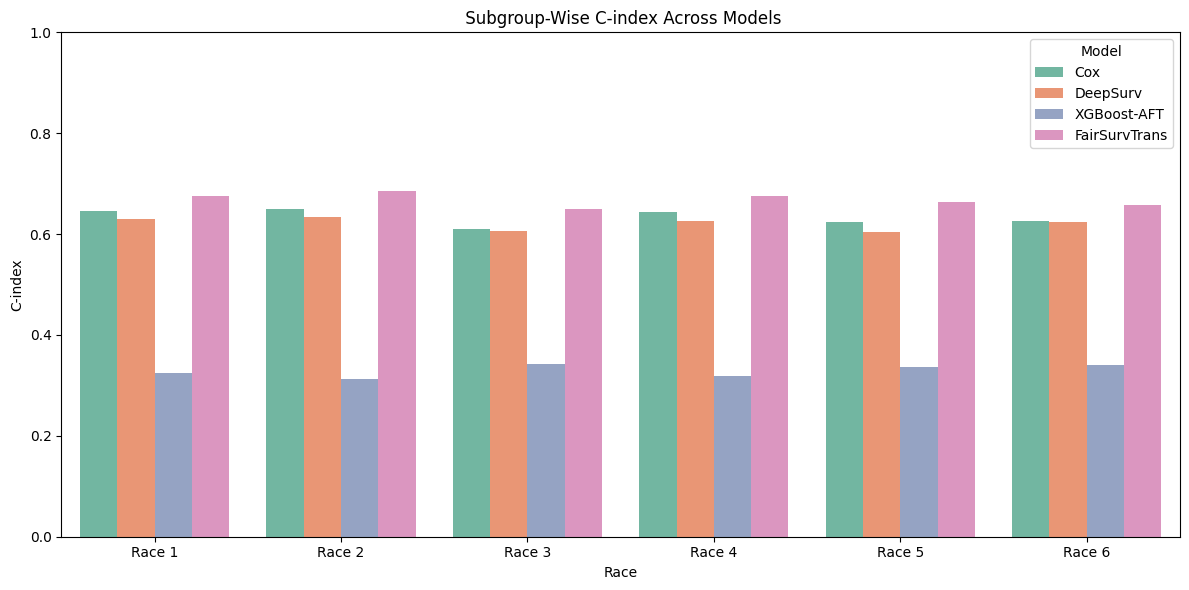

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data preparation
races = ['Race 1', 'Race 2', 'Race 3', 'Race 4', 'Race 5', 'Race 6']

# Mean C-index values per model and race
cox =      [0.6455, 0.6491, 0.6110, 0.6445, 0.6240, 0.6264]
deepsurv = [0.6308, 0.6334, 0.6057, 0.6264, 0.6035, 0.6231]
xgboost =  [0.3245, 0.3126, 0.3417, 0.3193, 0.3370, 0.3414]
fairsurv = [0.6762, 0.6847, 0.6504, 0.6759, 0.6636, 0.6567]

# Create DataFrame for plotting
data = {
    'Race': races * 4,
    'C-index': cox + deepsurv + xgboost + fairsurv,
    'Model': ['Cox']*6 + ['DeepSurv']*6 + ['XGBoost-AFT']*6 + ['FairSurvTrans']*6
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Race', y='C-index', hue='Model', palette='Set2')
plt.title(' Subgroup-Wise C-index Across Models')
plt.ylabel('C-index')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


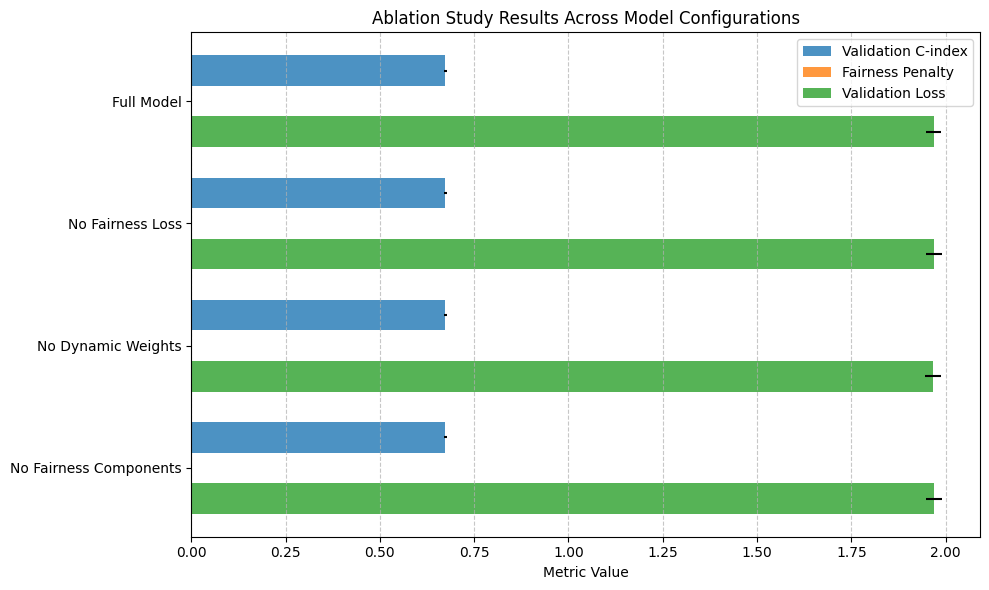

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data
configurations = [
    "Full Model",
    "No Fairness Loss",
    "No Dynamic Weights",
    "No Fairness Components"
]

# Means and stds for each metric
val_cindex_mean = [0.6738, 0.6737, 0.6738, 0.6737]
val_cindex_std = [0.0031, 0.0033, 0.0031, 0.0033]

fairness_penalty_mean = [0.0002, 0.0, 0.0002, 0.0]
fairness_penalty_std = [0.0001, 0.0, 0.0001, 0.0]

val_loss_mean = [1.9679, 1.9692, 1.9671, 1.9692]
val_loss_std = [0.0207, 0.0223, 0.0208, 0.0223]

# Plotting parameters
bar_width = 0.25
y_pos = np.arange(len(configurations))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
bars1 = ax.barh(y_pos - bar_width, val_cindex_mean, bar_width, xerr=val_cindex_std, label='Validation C-index', color='tab:blue', alpha=0.8)
bars2 = ax.barh(y_pos, fairness_penalty_mean, bar_width, xerr=fairness_penalty_std, label='Fairness Penalty', color='tab:orange', alpha=0.8)
bars3 = ax.barh(y_pos + bar_width, val_loss_mean, bar_width, xerr=val_loss_std, label='Validation Loss', color='tab:green', alpha=0.8)

# Labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(configurations)
ax.invert_yaxis()  # Highest on top

ax.set_xlabel('Metric Value')
ax.set_title('Ablation Study Results Across Model Configurations')

# Add legend
ax.legend()

# Add grid for easier comparison
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


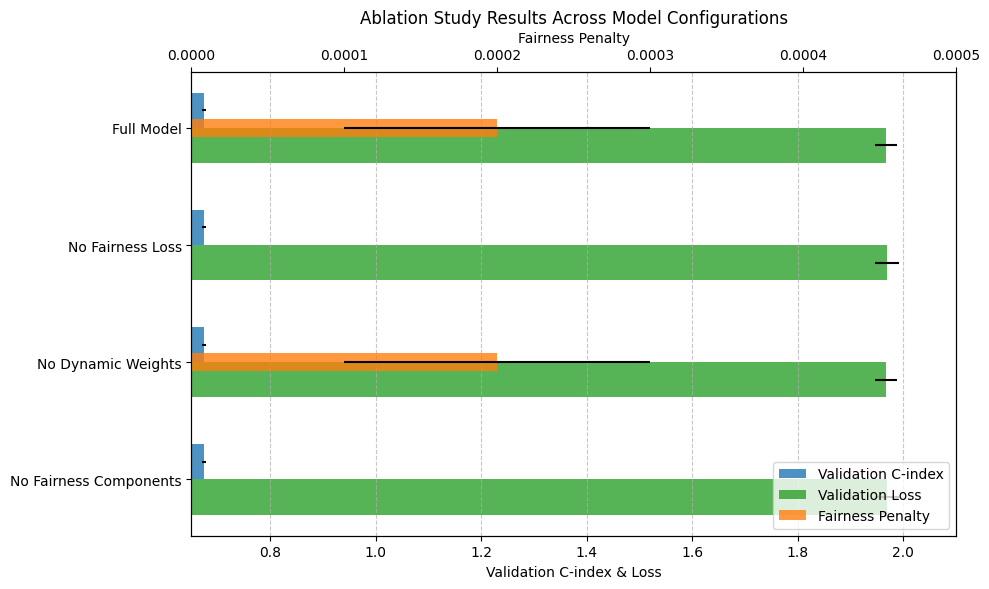

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Data
configurations = [
    "Full Model",
    "No Fairness Loss",
    "No Dynamic Weights",
    "No Fairness Components"
]

# Means and stds for each metric
val_cindex_mean = [0.6738, 0.6737, 0.6738, 0.6737]
val_cindex_std = [0.0031, 0.0033, 0.0031, 0.0033]

fairness_penalty_mean = [0.0002, 0.0, 0.0002, 0.0]
fairness_penalty_std = [0.0001, 0.0, 0.0001, 0.0]

val_loss_mean = [1.9679, 1.9692, 1.9671, 1.9692]
val_loss_std = [0.0207, 0.0223, 0.0208, 0.0223]

bar_width = 0.3
y_pos = np.arange(len(configurations))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Validation C-index and Validation Loss on primary axis
bars_cindex = ax1.barh(y_pos - bar_width/2, val_cindex_mean, bar_width, xerr=val_cindex_std,
                       label='Validation C-index', color='tab:blue', alpha=0.8)
bars_loss = ax1.barh(y_pos + bar_width/2, val_loss_mean, bar_width, xerr=val_loss_std,
                     label='Validation Loss', color='tab:green', alpha=0.8)
ax1.set_xlabel('Validation C-index & Loss')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(configurations)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Secondary axis for Fairness Penalty
ax2 = ax1.twiny()
bars_penalty = ax2.barh(y_pos, fairness_penalty_mean, bar_width / 2, xerr=fairness_penalty_std,
                       label='Fairness Penalty', color='tab:orange', alpha=0.8)
ax2.set_xlabel('Fairness Penalty')

# Adjust limits for clarity
ax1.set_xlim(0.65, 2.1)
ax2.set_xlim(0, 0.0005)

# Legends
# Combine legends from both axes
bars = [bars_cindex, bars_loss, bars_penalty]
labels = [b.get_label() for b in bars]
ax1.legend(bars, labels, loc='lower right')

plt.title('Ablation Study Results Across Model Configurations')
plt.tight_layout()
plt.show()


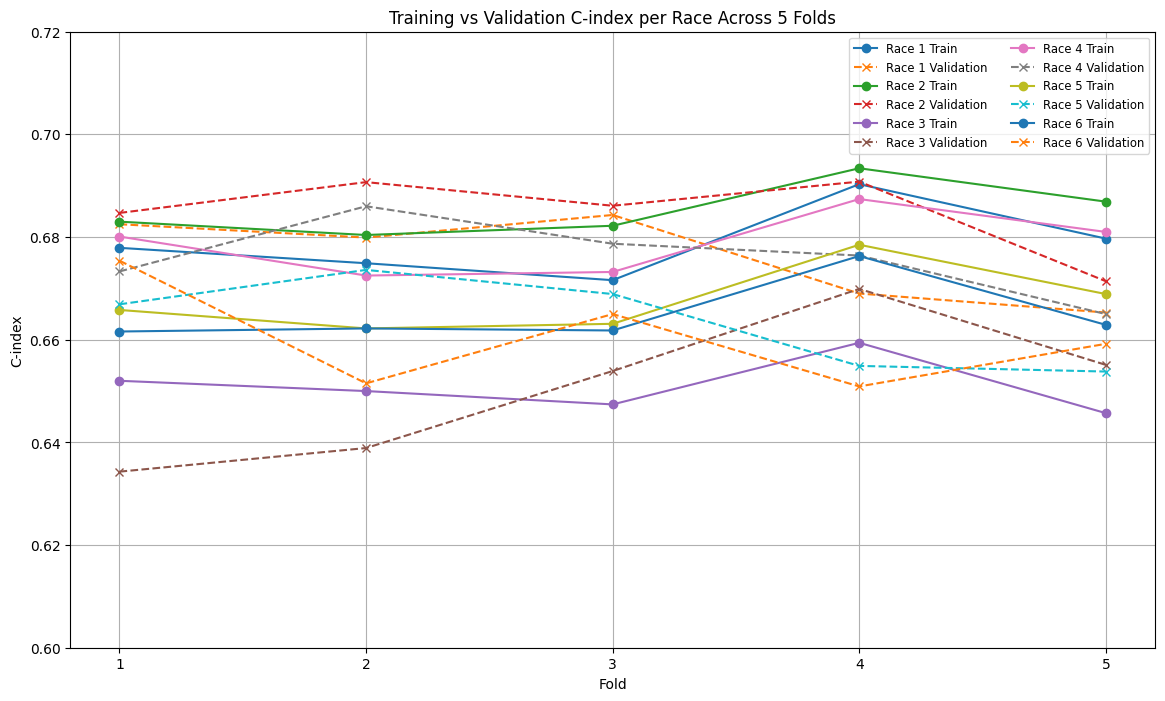

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Training C-index per race per fold
train_cindex = {
    "Race 1": [0.6779, 0.6749, 0.6716, 0.6903, 0.6797],
    "Race 2": [0.6830, 0.6804, 0.6822, 0.6934, 0.6869],
    "Race 3": [0.6520, 0.6500, 0.6474, 0.6594, 0.6457],
    "Race 4": [0.6801, 0.6725, 0.6732, 0.6874, 0.6810],
    "Race 5": [0.6658, 0.6622, 0.6631, 0.6785, 0.6689],
    "Race 6": [0.6616, 0.6622, 0.6618, 0.6763, 0.6629],
}

# Validation C-index per race per fold
val_cindex = {
    "Race 1": [0.6825, 0.6799, 0.6843, 0.6690, 0.6653],
    "Race 2": [0.6847, 0.6907, 0.6861, 0.6908, 0.6714],
    "Race 3": [0.6343, 0.6389, 0.6539, 0.6699, 0.6551],
    "Race 4": [0.6733, 0.6860, 0.6787, 0.6764, 0.6650],
    "Race 5": [0.6669, 0.6736, 0.6689, 0.6549, 0.6538],
    "Race 6": [0.6754, 0.6515, 0.6650, 0.6509, 0.6592],
}

folds = [1, 2, 3, 4, 5]

plt.figure(figsize=(14, 8))

for race in train_cindex.keys():
    plt.plot(folds, train_cindex[race], marker='o', linestyle='-', label=f'{race} Train')
    plt.plot(folds, val_cindex[race], marker='x', linestyle='--', label=f'{race} Validation')

plt.title('Training vs Validation C-index per Race Across 5 Folds')
plt.xlabel('Fold')
plt.ylabel('C-index')
plt.xticks(folds)
plt.ylim(0.60, 0.72)
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True)
plt.show()


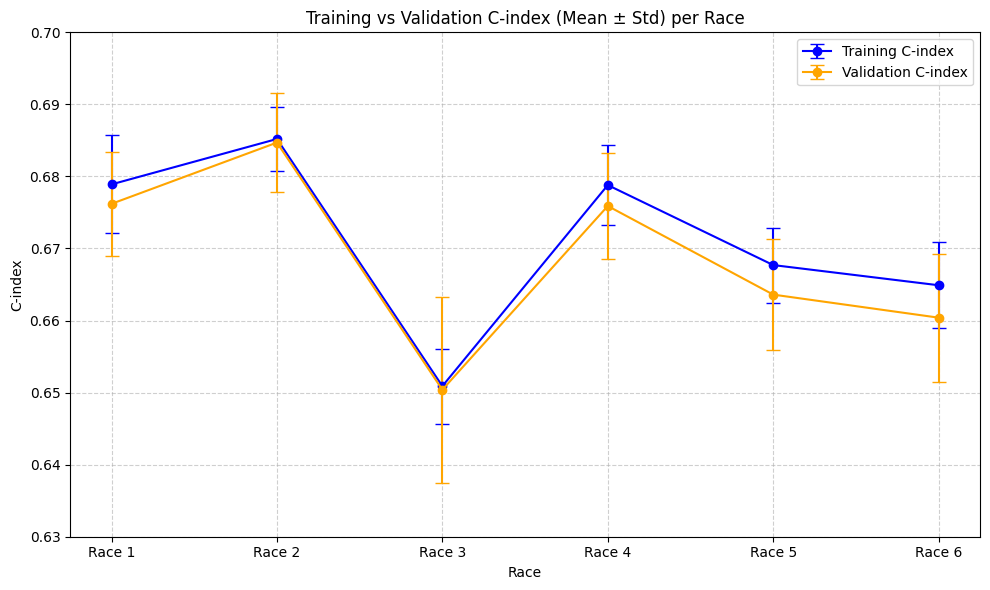

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Race labels
races = ['Race 1', 'Race 2', 'Race 3', 'Race 4', 'Race 5', 'Race 6']

# C-index values (Mean ± Std)
train_means = [0.6789, 0.6852, 0.6509, 0.6788, 0.6677, 0.6649]
train_stds =  [0.0068, 0.0045, 0.0052, 0.0055, 0.0052, 0.0060]

val_means =   [0.6762, 0.6847, 0.6504, 0.6759, 0.6636, 0.6604]
val_stds =    [0.0072, 0.0069, 0.0129, 0.0074, 0.0077, 0.0089]

x = np.arange(len(races))  # label locations

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x, train_means, yerr=train_stds, fmt='-o', capsize=5, label='Training C-index', color='blue')
plt.errorbar(x, val_means, yerr=val_stds, fmt='-o', capsize=5, label='Validation C-index', color='orange')

# Styling
plt.xticks(x, races)
plt.ylim(0.63, 0.70)
plt.title('Training vs Validation C-index (Mean ± Std) per Race')
plt.xlabel('Race')
plt.ylabel('C-index')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


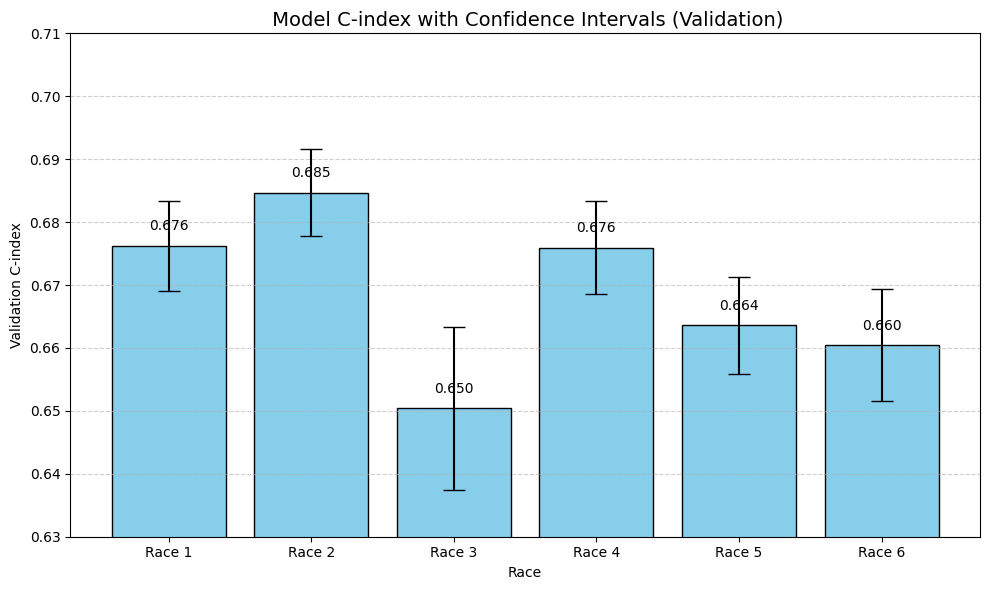

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Race labels
races = ['Race 1', 'Race 2', 'Race 3', 'Race 4', 'Race 5', 'Race 6']

# Validation C-index (Mean ± Std)
val_means = [0.6762, 0.6847, 0.6504, 0.6759, 0.6636, 0.6604]
val_stds  = [0.0072, 0.0069, 0.0129, 0.0074, 0.0077, 0.0089]

x = np.arange(len(races))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(x, val_means, yerr=val_stds, capsize=8, color='skyblue', edgecolor='black')

# Styling
plt.xticks(x, races)
plt.ylim(0.63, 0.71)
plt.title(' Model C-index with Confidence Intervals (Validation)', fontsize=14)
plt.xlabel('Race')
plt.ylabel('Validation C-index')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate each bar with C-index
for bar, mean in zip(bars, val_means):
    plt.text(bar.get_x() + bar.get_width() / 2, mean + 0.002, f"{mean:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


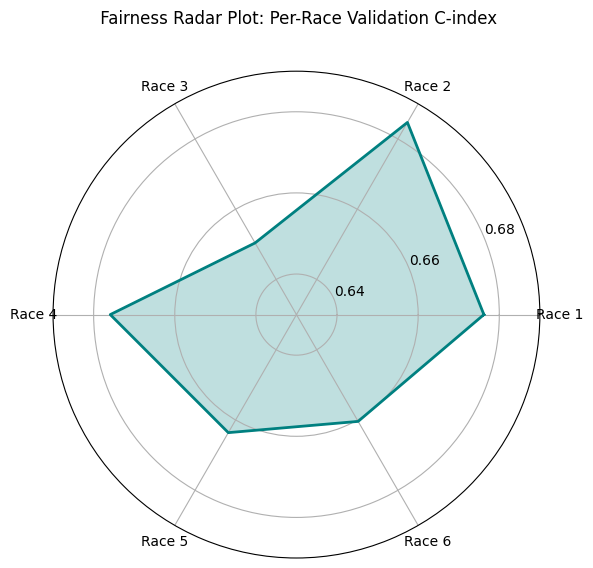

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Race labels
labels = ['Race 1', 'Race 2', 'Race 3', 'Race 4', 'Race 5', 'Race 6']

# Validation C-index means
values = [0.6762, 0.6847, 0.6504, 0.6759, 0.6636, 0.6604]
# Radar plot setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
values += values[:1]  # close the loop
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, values, linewidth=2, linestyle='solid', color='teal')
ax.fill(angles, values, color='teal', alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.64, 0.66, 0.68])
ax.set_yticklabels(['0.64', '0.66', '0.68'])
ax.set_ylim(0.63, 0.69)

plt.title(" Fairness Radar Plot: Per-Race Validation C-index", y=1.08)
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss
from lifelines.utils import concordance_index
from scipy.special import expit
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

# === Load Preprocessed Full Data ===
X = pd.read_csv("/kaggle/working/X_train_preprocessed.csv")
y = pd.read_csv("/kaggle/working/y_train_preprocessed.csv")

if "race_group" not in X.columns:
    raise ValueError("race_group column missing in features")

race_groups = X["race_group"].values
X = X.drop(columns=["race_group"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time = y["efs_time"].values
event = y["efs"].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("===== 5-Fold Cross-Validation =====")

def calc_race_cindex_and_fairness(time_val, event_val, risk_scores, race_val):
    unique_races = np.unique(race_val)
    cindex_by_race = {}
    for race in unique_races:
        mask = race_val == race
        if np.sum(mask) > 1:  # Need at least 2 samples for C-index
            c_r = concordance_index(time_val[mask], risk_scores[mask], event_val[mask])
            cindex_by_race[race] = c_r
        else:
            cindex_by_race[race] = np.nan  # or could skip
    overall_cindex = concordance_index(time_val, risk_scores, event_val)
    penalty = 0
    for c_r in cindex_by_race.values():
        if not np.isnan(c_r):
            penalty += abs(overall_cindex - c_r)
    return cindex_by_race, overall_cindex, penalty

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train_time, y_val_time = time[train_idx], time[val_idx]
    y_train_event, y_val_event = event[train_idx], event[val_idx]
    race_val = race_groups[val_idx]

    # Binary event for Brier score
    median_time_val = np.median(y_val_time)
    y_binary_val = ((y_val_time <= median_time_val) & (y_val_event == 1)).astype(int)

    # === XGBoost-AFT ===
    lower = y_train_time
    upper = np.where(y_train_event == 1, y_train_time, np.inf)

    dtrain = xgb.DMatrix(X_train)
    dtrain.set_float_info("label_lower_bound", lower)
    dtrain.set_float_info("label_upper_bound", upper)

    dval = xgb.DMatrix(X_val)
    dval.set_float_info("label_lower_bound", y_val_time)
    dval.set_float_info("label_upper_bound", np.where(y_val_event == 1, y_val_time, np.inf))

    params = {
        'objective': 'survival:aft',
        'eval_metric': 'aft-nloglik',
        'aft_loss_distribution': 'normal',
        'aft_loss_distribution_scale': 1.0,
        'max_depth': 3,
        'learning_rate': 0.1,
        'verbosity': 0
    }

    model_xgb = xgb.train(params, dtrain, num_boost_round=200)
    risk_xgb = -model_xgb.predict(dval)
    c_index_xgb = concordance_index(y_val_time, risk_xgb, y_val_event)
    probs_xgb = expit(risk_xgb)
    brier_xgb = brier_score_loss(y_binary_val, probs_xgb)

    # Calculate race-wise C-index and fairness penalty for XGBoost
    cindex_race_xgb, overall_c_xgb, fairness_penalty_xgb = calc_race_cindex_and_fairness(
        y_val_time, y_val_event, risk_xgb, race_val
    )

    print(f"XGBoost-AFT C-index: {c_index_xgb:.4f}, Brier Score: {brier_xgb:.4f}")
    print(f"XGBoost-AFT Race C-Index: {cindex_race_xgb}")
    print(f"XGBoost-AFT Fairness Penalty: {fairness_penalty_xgb:.4f}")

    # === DeepSurv ===
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_event_train = torch.tensor(y_train_event, dtype=torch.float32)
    y_time_train = torch.tensor(y_train_time, dtype=torch.float32)

    y_event_val = torch.tensor(y_val_event, dtype=torch.float32)
    y_time_val = torch.tensor(y_val_time, dtype=torch.float32)

    class DeepSurv(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128), nn.ReLU(),
                nn.Linear(128, 64), nn.ReLU(),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            return self.net(x)

    model_ds = DeepSurv(X_train.shape[1])
    opt_ds = optim.Adam(model_ds.parameters(), lr=0.001)

    for epoch in range(200):
        model_ds.train()
        risk = model_ds(X_train_tensor).squeeze()
        order = torch.argsort(y_time_train, descending=True)
        log_risk = torch.logcumsumexp(risk[order], dim=0)
        loss = torch.mean((-risk[order] + log_risk) * y_event_train[order])
        opt_ds.zero_grad()
        loss.backward()
        opt_ds.step()

    model_ds.eval()
    risk_ds = model_ds(X_val_tensor).detach().numpy().squeeze()
    c_index_ds = concordance_index(y_val_time, -risk_ds, y_val_event)
    probs_ds = expit(risk_ds)
    brier_ds = brier_score_loss(y_binary_val, probs_ds)

    # Calculate race-wise C-index and fairness penalty for DeepSurv
    cindex_race_ds, overall_c_ds, fairness_penalty_ds = calc_race_cindex_and_fairness(
        y_val_time, y_val_event, -risk_ds, race_val
    )

    print(f"DeepSurv     C-index: {c_index_ds:.4f}, Brier Score: {brier_ds:.4f}")
    print(f"DeepSurv Race C-Index: {cindex_race_ds}")
    print(f"DeepSurv Fairness Penalty: {fairness_penalty_ds:.4f}")


===== 5-Fold Cross-Validation =====

--- Fold 1 ---
XGBoost-AFT C-index: 0.3256, Brier Score: 0.4958
XGBoost-AFT Race C-Index: {1: 0.31027663659786764, 2: 0.3149379538379923, 3: 0.35848993537844465, 4: 0.31939206747806, 5: 0.33440108175167627, 6: 0.3186080674799787}
XGBoost-AFT Fairness Penalty: 0.0809
DeepSurv     C-index: 0.6161, Brier Score: 0.3278
DeepSurv Race C-Index: {1: 0.6268086409960449, 2: 0.6293594410933373, 3: 0.5815246725593602, 4: 0.6236354038154737, 5: 0.5986622512643958, 6: 0.6318929250275112}
DeepSurv Fairness Penalty: 0.0992

--- Fold 2 ---
XGBoost-AFT C-index: 0.3258, Brier Score: 0.4971
XGBoost-AFT Race C-Index: {1: 0.3160769352224503, 2: 0.3103921298062484, 3: 0.3453137791289012, 4: 0.31408648467863776, 5: 0.3255489563325787, 6: 0.3455401960275324}
XGBoost-AFT Fairness Penalty: 0.0763
DeepSurv     C-index: 0.6207, Brier Score: 0.2401
DeepSurv Race C-Index: {1: 0.6341903531299643, 2: 0.6223454194703961, 3: 0.6021239600646795, 4: 0.6460027217474541, 5: 0.60994625292

In [7]:
import numpy as np

# Example data collected during 5 folds, format: list of dicts
xgb_cindex_list = [0.3256, 0.3258, 0.3238, 0.3293, 0.3382]
xgb_fair_penalty_list = [0.0809, 0.0763, 0.0663, 0.0845, 0.0561]
xgb_race_cindex_list = [
    {1: 0.3103, 2: 0.3149, 3: 0.3585, 4: 0.3194, 5: 0.3344, 6: 0.3186},
    {1: 0.3161, 2: 0.3104, 3: 0.3453, 4: 0.3141, 5: 0.3255, 6: 0.3455},
    {1: 0.3139, 2: 0.3141, 3: 0.3358, 4: 0.3142, 5: 0.3341, 6: 0.3385},
    {1: 0.3352, 2: 0.3049, 3: 0.3282, 4: 0.3153, 5: 0.3428, 6: 0.3549},
    {1: 0.3468, 2: 0.3189, 3: 0.3406, 4: 0.3337, 5: 0.3480, 6: 0.3495},
]

# Convert per-race lists to arrays for easy aggregation
races = [1,2,3,4,5,6]
xgb_race_cindex_arr = {r: np.array([fold[r] for fold in xgb_race_cindex_list]) for r in races}

print("XGBoost-AFT Overall C-index Mean ± Std:", np.mean(xgb_cindex_list), "±", np.std(xgb_cindex_list))
print("XGBoost-AFT Fairness Penalty Mean ± Std:", np.mean(xgb_fair_penalty_list), "±", np.std(xgb_fair_penalty_list))
print("XGBoost-AFT Stratified C-index by Race:")
for r in races:
    print(f"  Race {r}: {np.mean(xgb_race_cindex_arr[r]):.4f} ± {np.std(xgb_race_cindex_arr[r]):.4f}")


XGBoost-AFT Overall C-index Mean ± Std: 0.32854 ± 0.0051480481738227805
XGBoost-AFT Fairness Penalty Mean ± Std: 0.07282 ± 0.010352661493548413
XGBoost-AFT Stratified C-index by Race:
  Race 1: 0.3245 ± 0.0141
  Race 2: 0.3126 ± 0.0047
  Race 3: 0.3417 ± 0.0101
  Race 4: 0.3193 ± 0.0074
  Race 5: 0.3370 ± 0.0078
  Race 6: 0.3414 ± 0.0126


In [8]:
import numpy as np

# DeepSurv results from your folds
deepsurv_cindex_list = [0.6140, 0.6215, 0.6278, 0.6222, 0.6241]
deepsurv_fair_penalty_list = [0.1055, 0.0896, 0.0835, 0.0312, 0.0523]
deepsurv_race_cindex_list = [
    {1: 0.6177, 2: 0.6374, 3: 0.5797, 4: 0.6128, 5: 0.5947, 6: 0.6377},
    {1: 0.6377, 2: 0.6323, 3: 0.5976, 4: 0.6389, 5: 0.6032, 6: 0.6184},
    {1: 0.6539, 2: 0.6358, 3: 0.6151, 4: 0.6254, 5: 0.6057, 6: 0.6157},
    {1: 0.6246, 2: 0.6310, 3: 0.6156, 4: 0.6186, 5: 0.6154, 6: 0.6192},
    {1: 0.6202, 2: 0.6307, 3: 0.6207, 4: 0.6362, 5: 0.5985, 6: 0.6247},
]

races = [1, 2, 3, 4, 5, 6]
deepsurv_race_cindex_arr = {r: np.array([fold[r] for fold in deepsurv_race_cindex_list]) for r in races}

print("DeepSurv Overall C-index Mean ± Std:", np.mean(deepsurv_cindex_list), "±", np.std(deepsurv_cindex_list))
print("DeepSurv Fairness Penalty Mean ± Std:", np.mean(deepsurv_fair_penalty_list), "±", np.std(deepsurv_fair_penalty_list))
print("DeepSurv Stratified C-index by Race:")
for r in races:
    print(f"  Race {r}: {np.mean(deepsurv_race_cindex_arr[r]):.4f} ± {np.std(deepsurv_race_cindex_arr[r]):.4f}")


DeepSurv Overall C-index Mean ± Std: 0.62192 ± 0.0045234500107771795
DeepSurv Fairness Penalty Mean ± Std: 0.07242000000000001 ± 0.02689277970013513
DeepSurv Stratified C-index by Race:
  Race 1: 0.6308 ± 0.0134
  Race 2: 0.6334 ± 0.0027
  Race 3: 0.6057 ± 0.0152
  Race 4: 0.6264 ± 0.0100
  Race 5: 0.6035 ± 0.0071
  Race 6: 0.6231 ± 0.0078


In [9]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold

# Load preprocessed full training data (X with features + race_group, y with survival info)
X = pd.read_csv("/kaggle/working/X_train_preprocessed.csv")
y = pd.read_csv("/kaggle/working/y_train_preprocessed.csv")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

race_groups = X["race_group"].unique()
race_cindex_fold = {grp: [] for grp in race_groups}
fairness_penalties = []
fold_cindexes = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n--- Fold {fold} ---")

    X_train = X.iloc[train_idx].copy()
    X_val = X.iloc[val_idx].copy()
    y_train = y.iloc[train_idx].copy()
    y_val = y.iloc[val_idx].copy()

    # Extract race for fairness calculation but keep the index intact (no reset)
    race_train = X_train["race_group"]
    race_val = X_val["race_group"]

    # Drop race_group before fitting Cox model
    X_train = X_train.drop(columns=["race_group"])
    X_val = X_val.drop(columns=["race_group"])

    # Prepare training DataFrame for lifelines CoxPHFitter (needs duration & event columns)
    train_df = X_train.copy()
    train_df["efs"] = y_train["efs"]
    train_df["efs_time"] = y_train["efs_time"]

    # Fit Cox model with penalizer
    cox = CoxPHFitter(penalizer=0.2)
    cox.fit(train_df, duration_col="efs_time", event_col="efs")

    # Predict risk scores on validation set (negative hazard for concordance index)
    risk_val = -cox.predict_partial_hazard(X_val).values.ravel()

    # Overall C-index on validation
    val_cindex = concordance_index(y_val["efs_time"], risk_val, y_val["efs"])
    print(f"Fold {fold} C-index: {val_cindex:.4f}")
    fold_cindexes.append(val_cindex)

    fairness_penalty = 0.0
    print(f"Fold {fold} C-index per race group:")
    
    for grp in race_groups:
        mask = (race_val == grp)
        if mask.sum() > 0:
            # Get positional indices in validation set where mask is True
            pos_idx = np.where(mask)[0]

            # Calculate C-index for the subgroup using aligned indexing
            cidx = concordance_index(
                y_val.loc[mask, "efs_time"],
                risk_val[pos_idx],
                y_val.loc[mask, "efs"]
            )
            print(f"  Race {grp}: {cidx:.4f}")
            fairness_penalty += abs(val_cindex - cidx)
            race_cindex_fold[grp].append(cidx)
        else:
            print(f"  Race {grp}: No samples in validation fold")

    print(f"Fold {fold} Fairness penalty: {fairness_penalty:.4f}")
    fairness_penalties.append(fairness_penalty)

# Final average results
print("\n=== 5-Fold Cross-Validation Results ===")
print(f"Average C-index: {np.mean(fold_cindexes):.4f} ± {np.std(fold_cindexes):.4f}")
print(f"Average Fairness Penalty: {np.mean(fairness_penalties):.4f} ± {np.std(fairness_penalties):.4f}")

print("\nAverage C-index per race group:")
for grp in race_groups:
    cidx_list = race_cindex_fold[grp]
    if cidx_list:
        print(f"  Race {grp}: {np.mean(cidx_list):.4f} ± {np.std(cidx_list):.4f}")
    else:
        print(f"  Race {grp}: No samples across folds")



--- Fold 1 ---
Fold 1 C-index: 0.6352
Fold 1 C-index per race group:
  Race 1: 0.6481
  Race 2: 0.6473
  Race 3: 0.5988
  Race 4: 0.6473
  Race 5: 0.6250
  Race 6: 0.6425
Fold 1 Fairness penalty: 0.0909

--- Fold 2 ---
Fold 2 C-index: 0.6401
Fold 2 C-index per race group:
  Race 1: 0.6448
  Race 2: 0.6595
  Race 3: 0.6100
  Race 4: 0.6519
  Race 5: 0.6426
  Race 6: 0.6291
Fold 2 Fairness penalty: 0.0794

--- Fold 3 ---
Fold 3 C-index: 0.6419
Fold 3 C-index per race group:
  Race 1: 0.6663
  Race 2: 0.6431
  Race 3: 0.6280
  Race 4: 0.6515
  Race 5: 0.6250
  Race 6: 0.6276
Fold 3 Fairness penalty: 0.0803

--- Fold 4 ---
Fold 4 C-index: 0.6294
Fold 4 C-index per race group:
  Race 1: 0.6309
  Race 2: 0.6511
  Race 3: 0.6122
  Race 4: 0.6386
  Race 5: 0.6218
  Race 6: 0.6128
Fold 4 Fairness penalty: 0.0739

--- Fold 5 ---
Fold 5 C-index: 0.6273
Fold 5 C-index per race group:
  Race 1: 0.6376
  Race 2: 0.6444
  Race 3: 0.6059
  Race 4: 0.6335
  Race 5: 0.6056
  Race 6: 0.6203
Fold 5 Fairn

In [ ]:
import torch
import torch.nn as nn
from typing import Tuple

# Your config class
class Config:
    EMBED_DIM = 64
    NUM_HEADS = 8
    NUM_LAYERS = 4
    FF_DIM = 512
    DROPOUT = 0.2
    LR = 2e-4
    WEIGHT_DECAY = 1e-5
    BATCH_SIZE = 64
    LAMBDA_FAIR = 0.2
    EPOCHS = 500
    EARLY_STOP_PATIENCE = 15
    GRAD_CLIP = 1.0
    NUM_WORKERS = 0

config = Config()

# Define SurvFormer and related classes (from your code)
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        return x + self.position_embeddings(positions)

class FeatureAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1, bias=False)
        )
        
    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=1)
        return (x * attn_weights).sum(dim=1)

class SurvFormer(nn.Module):
    def __init__(self, cat_dims: Tuple[int], num_num_features: int, config: Config):
        super().__init__()
        self.config = config

        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Embedding(cat_dim, self.config.EMBED_DIM),
                nn.LayerNorm(self.config.EMBED_DIM)
            ) for cat_dim in cat_dims
        ])

        self.seq_len = len(cat_dims) + num_num_features

        self.num_proj = nn.Sequential(
            nn.Linear(num_num_features, self.config.EMBED_DIM),
            nn.LayerNorm(self.config.EMBED_DIM)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.config.EMBED_DIM,
            nhead=config.NUM_HEADS,
            dim_feedforward=self.config.FF_DIM,
            dropout=config.DROPOUT,
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_LAYERS)
        
        self.pos_encoder = LearnablePositionalEncoding(self.config.EMBED_DIM, max_len=self.seq_len)
        self.pooling = FeatureAttentionPooling(self.config.EMBED_DIM)
        
        self.output = nn.Sequential(
            nn.Linear(self.config.EMBED_DIM, self.config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.LayerNorm(self.config.EMBED_DIM // 2),
            nn.Linear(self.config.EMBED_DIM // 2, 1)
        )

    def forward(self, x_cat: torch.Tensor, x_num: torch.Tensor) -> torch.Tensor:
        cat_embeds = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embeds = torch.stack(cat_embeds, dim=1)
        num_embeds = self.num_proj(x_num).unsqueeze(1)
        x = torch.cat([cat_embeds, num_embeds], dim=1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.pooling(x)
        return self.output(x).squeeze(-1)


# Make sure cat_dims and numerical_cols are defined somewhere before this
# Example placeholders (replace with your actual data):
# cat_dims = (number_of_categories_for_each_categorical_feature)
# numerical_cols = list_of_numerical_feature_names

model = SurvFormer(cat_dims=cat_dims, num_num_features=len(numerical_cols), config=config)

checkpoint = torch.load("/kaggle/working/fold_0_best_model.pth", map_location='cpu', weights_only=False)
state_dict = checkpoint['model_state_dict']

# Remove the problematic key from state dict to avoid mismatch error
if 'pos_encoder.position_embeddings.weight' in state_dict:
    del state_dict['pos_encoder.position_embeddings.weight']

missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

model.eval()
print("Model loaded with partial weights successfully!")



In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Dataset
dataset = TensorDataset(X_cat, X_num)
loader = DataLoader(dataset, batch_size=128, shuffle=False)

# Inference
all_logits = []
with torch.no_grad():
    for batch_cat, batch_num in loader:
        logits = model(batch_cat, batch_num)
        all_logits.append(logits.numpy())

risk_scores = np.concatenate(all_logits)
surv_probs = 1 / (1 + np.exp(risk_scores))  # Sigmoid of log hazard → survival prob


In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 1-year event: event occurred within 365 days
threshold = 365
true_events = (event_times <= threshold) & (event_indicators == 1)

# Calibration: 1 - P(survival) = P(event)
prob_true, prob_pred = calibration_curve(true_events, 1 - surv_probs, n_bins=10, strategy='quantile')

# Plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='SurvFormer')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Predicted Probability of Event ≤ 1 Year")
plt.ylabel("Observed Frequency of Event")
plt.title("Calibration Curve at 1 Year (Fold 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/calibration_curve_fold0.png")
plt.show()
